In [2]:
pip install optuna lofo-importance BorutaShap scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 689.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but

In [1]:

import os # Để xử lý đường dẫn file
import traceback
import xgboost
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import optuna
from xgboost import XGBClassifier
import shap
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.inspection import permutation_importance
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import StratifiedKFold
from BorutaShap import BorutaShap


import warnings # Thêm để quản lý warnings từ các thư viện

import xgboost
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import optuna
from xgboost import XGBClassifier
import shap
from sklearn.inspection import permutation_importance
from lofo import LOFOImportance, Dataset # plot_importance không được dùng trong code của bạn
from sklearn.model_selection import StratifiedKFold
from BorutaShap import BorutaShap

# Tắt các warnings không cần thiết từ Optuna và các thư viện khác nếu muốn
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore', category=UserWarning) # Ví dụ: tắt UserWarning
warnings.filterwarnings('ignore', category=FutureWarning) # Ví dụ: tắt FutureWarning

In [2]:
# --- Hằng số ---
RANDOM_STATE_GENERAL = 42 # Dùng chung cho các StratifiedKFold, BorutaShap
RANDOM_STATE_OPTIMIZE_SAMPLER = 42 # Seed cho TPESampler của Optuna
RANDOM_STATE_PERMUTATION = 0 # Seed riêng cho PermutationImportance
N_REPEATS_PERMUTATION = 2
DEFAULT_N_SPLITS_CV = 5
FAST_N_SPLITS_CV = 2
DEFAULT_BORUTA_N_TRIALS = 10
FAST_BORUTA_N_TRIALS = 2
EARLY_STOPPING_ROUNDS_OPT = 50 # Early stopping cho quá trình optimize

# (Giữ nguyên các import khác của bạn như XGBClassifier, roc_auc_score, StratifiedKFold, etc.)
# Ví dụ các import cần thiết:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
import shap
from lofo import LOFOImportance, Dataset
from BorutaShap import BorutaShap
import optuna
import os
import traceback


# --- Hàm Optimize Hyperparameters --- (Giữ nguyên hàm optimize của bạn)
def optimize(X_train, y_train, X_val, y_val, monotone_constraints_dict, n_trials=1, dart=False):
    """Hàm tối ưu hóa siêu tham số cho XGBoost sử dụng Optuna."""
    def objective(trial, current_X_train, current_y_train, current_X_val, current_y_val, current_monotone_constraints_dict):
        param_for_xgb = {
            'random_state': RANDOM_STATE_GENERAL,
            'n_jobs': -1,
            'n_estimators': trial.suggest_int('n_estimators', 200, 600),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'early_stopping_rounds': EARLY_STOPPING_ROUNDS_OPT,
            'eval_metric': 'auc'
        }

        if dart:
            model = XGBClassifier(**param_for_xgb, booster='dart', tree_method='exact', monotone_constraints=current_monotone_constraints_dict)
        else:
            model = XGBClassifier(**param_for_xgb, tree_method='exact', monotone_constraints=current_monotone_constraints_dict)

        model.fit(
            current_X_train, current_y_train,
            eval_set=[(current_X_val, current_y_val)],
            verbose=False
        )

        y_val_pred = model.predict_proba(current_X_val)[:, 1]
        auc_sc = roc_auc_score(current_y_val, y_val_pred)

        return auc_sc

    sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE_OPTIMIZE_SAMPLER)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, monotone_constraints_dict), n_trials=n_trials)

    print('Số trials đã hoàn thành trong quá trình tối ưu siêu tham số:', len(study.trials))

    return study

# --- Hàm aggregate_fold_importances ĐÃ SỬA ---
def aggregate_fold_importances(fold_importances_list, output_importance_col_name):
    """
    Tổng hợp feature importance từ nhiều fold.
    Trả về DataFrame với cột 'Feature' và cột importance trung bình đã được đặt tên.
    """
    if not fold_importances_list:
        return pd.DataFrame(columns=['Feature', output_importance_col_name])

    num_folds = len(fold_importances_list)
    if num_folds == 0:
        return pd.DataFrame(columns=['Feature', output_importance_col_name])

    # Chuyển list các dict thành DataFrame, với features là index, các fold là cột
    # fillna(0) để các feature không có trong 1 fold nào đó sẽ có giá trị 0 cho fold đó
    temp_df = pd.DataFrame(fold_importances_list).T.fillna(0)

    # Tính tổng importance cho mỗi feature qua các fold, sau đó chia cho số lượng fold
    # Điều này tương đương với việc tính trung bình, coi các feature không xuất hiện ở fold nào đó có importance là 0
    averaged_importances = temp_df.sum(axis=1) / num_folds

    df_result = averaged_importances.rename_axis('Feature').to_frame(output_importance_col_name)
    df_result = df_result.reset_index()

    return df_result

# --- Hàm tính toán và tổng hợp Feature Importances (Phần XGBoost built-in đã được cập nhật) ---
def get_all_importances_df(X_train, y_train, X_val, y_val,
                           monotone_constraints_dict, importance_result_folder_path,
                           n_trials_optuna=1, use_fast=False):
    print("*** Tối ưu hóa siêu tham số với toàn bộ feature gốc...")
    study = optimize(X_train, y_train, X_val, y_val, monotone_constraints_dict, n_trials=n_trials_optuna)
    best_params_from_optuna = study.best_params

    final_model_params = {
        'random_state': RANDOM_STATE_GENERAL,
        'n_jobs': -1,
        'eval_metric': 'auc',
    }
    final_model_params.update(best_params_from_optuna)

    print("\n*** Huấn luyện mô hình gốc đã được tune trên toàn bộ X_train (eval trên X_val)...")
    origin_model_params_for_fit = final_model_params.copy()
    origin_model_params_for_fit['early_stopping_rounds'] = EARLY_STOPPING_ROUNDS_OPT

    # Giả sử không dùng DART cho model gốc này nếu không có thông tin dart từ optimize
    # Nếu hàm optimize của bạn có trả về `dart` hoặc bạn muốn truyền dart vào đây, hãy cập nhật logic
    is_dart_model = 'booster' in best_params_from_optuna and best_params_from_optuna['booster'] == 'dart'

    if is_dart_model:
        origin_model_tuned = XGBClassifier(**origin_model_params_for_fit, booster='dart', tree_method='exact', monotone_constraints=monotone_constraints_dict)
    else:
        origin_model_tuned = XGBClassifier(**origin_model_params_for_fit, tree_method='exact', monotone_constraints=monotone_constraints_dict)

    origin_model_tuned.fit(X_train, y_train,
                           eval_set=[(X_val, y_val)], verbose=False)

    num_cv_splits = FAST_N_SPLITS_CV if use_fast else DEFAULT_N_SPLITS_CV
    skf = StratifiedKFold(n_splits=num_cv_splits, shuffle=True, random_state=RANDOM_STATE_GENERAL)

    params_for_fold_training = final_model_params.copy()
    if 'early_stopping_rounds' in params_for_fold_training:
        del params_for_fold_training['early_stopping_rounds']

    # --- 1. XGBoost Built-in Importances (Weight, Gain, Total Gain) với CV ---
    print(f"\n*** Đang tính Importance từ mô hình XGBoost với {num_cv_splits}-Fold CV trên (X_train, y_train)...")
    fold_weight_importances = []
    fold_gain_importances = []
    fold_total_gain_importances = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"   XGB Built-in - Fold {fold+1}/{num_cv_splits}")
        X_train_fold, _ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, _ = y_train.iloc[train_idx], y_train.iloc[val_idx]

        current_monotone_constraints = {
            k: v for k, v in (monotone_constraints_dict or {}).items() if k in X_train_fold.columns
        }
        if not current_monotone_constraints: current_monotone_constraints = None

        # Quyết định booster cho model_fold dựa trên best_params_from_optuna
        if is_dart_model:
            model_fold = XGBClassifier(**params_for_fold_training, booster='dart', tree_method='exact', monotone_constraints=current_monotone_constraints)
        else:
            model_fold = XGBClassifier(**params_for_fold_training, tree_method='exact', monotone_constraints=current_monotone_constraints)

        model_fold.fit(X_train_fold, y_train_fold, verbose=False)

        booster = model_fold.get_booster()
        fold_weight_importances.append(booster.get_score(importance_type='weight'))
        fold_gain_importances.append(booster.get_score(importance_type='gain'))
        fold_total_gain_importances.append(booster.get_score(importance_type='total_gain'))

    all_features = X_train.columns.tolist()
    # Sửa đổi cách gọi aggregate_fold_importances và bỏ các dòng .rename không cần thiết
    df_weight_avg = aggregate_fold_importances(fold_weight_importances, 'Weight_Importance_Avg')
    df_gain_avg = aggregate_fold_importances(fold_gain_importances, 'Gain_Importance_Avg')
    df_total_gain_avg = aggregate_fold_importances(fold_total_gain_importances, 'Total_Gain_Importance_Avg')

    # Các dòng rename này không còn cần thiết nữa:
    # df_weight_avg = df_weight_avg.rename(columns={'Importance': 'Weight_Importance_Avg'})
    # df_gain_avg = df_gain_avg.rename(columns={'Importance': 'Gain_Importance_Avg'})
    # df_total_gain_avg = df_total_gain_avg.rename(columns={'Importance': 'Total_Gain_Importance_Avg'})

    xgb_importance_df = pd.DataFrame({'Feature': all_features})
    if not df_weight_avg.empty:
        xgb_importance_df = pd.merge(xgb_importance_df, df_weight_avg, on='Feature', how='left')
    if not df_gain_avg.empty:
        xgb_importance_df = pd.merge(xgb_importance_df, df_gain_avg, on='Feature', how='left')
    if not df_total_gain_avg.empty:
        xgb_importance_df = pd.merge(xgb_importance_df, df_total_gain_avg, on='Feature', how='left')

    xgb_importance_df = xgb_importance_df.fillna(0)

    # Các dòng này bây giờ sẽ hoạt động đúng vì các cột importance là duy nhất
    xgb_importance_df['Weight_Rank'] = xgb_importance_df['Weight_Importance_Avg'].rank(ascending=False, method='min')
    xgb_importance_df['Gain_Rank'] = xgb_importance_df['Gain_Importance_Avg'].rank(ascending=False, method='min')
    xgb_importance_df['Total_Gain_Rank'] = xgb_importance_df['Total_Gain_Importance_Avg'].rank(ascending=False, method='min')
    xgb_importance_df = xgb_importance_df[['Feature', 'Weight_Rank', 'Gain_Rank', 'Total_Gain_Rank']]

    # --- 2. Permutation Importance với CV --- (Giữ nguyên phần còn lại của hàm)
    print(f"\n*** Đang tính Permutation Importance với {num_cv_splits}-Fold CV trên (X_train, y_train)...")
    all_perm_importances = pd.DataFrame({'Feature': X_train.columns})
    fold_perm_scores_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"   Permutation - Fold {fold+1}/{num_cv_splits}")
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        current_monotone_constraints = {
            k: v for k, v in (monotone_constraints_dict or {}).items() if k in X_train_fold.columns
        }
        if not current_monotone_constraints: current_monotone_constraints = None

        if is_dart_model:
            model_fold = XGBClassifier(**params_for_fold_training, booster='dart', tree_method='exact', monotone_constraints=current_monotone_constraints)
        else:
            model_fold = XGBClassifier(**params_for_fold_training, tree_method='exact', monotone_constraints=current_monotone_constraints)
        model_fold.fit(X_train_fold, y_train_fold, verbose=False)

        r = permutation_importance(model_fold, X_val_fold, y_val_fold,
                                   n_repeats=N_REPEATS_PERMUTATION,
                                   random_state=RANDOM_STATE_PERMUTATION, n_jobs=-1)

        perm_imp_fold_df = pd.DataFrame({'Feature': X_val_fold.columns, f'Perm_Imp_Fold_{fold+1}': r.importances_mean})
        fold_perm_scores_list.append(perm_imp_fold_df.set_index('Feature'))

    if fold_perm_scores_list:
        perm_importances_agg_df = pd.concat(fold_perm_scores_list, axis=1).mean(axis=1).reset_index()
        perm_importances_agg_df.columns = ['Feature', 'Perm_Importance_Mean_Avg']
        perm_importances_agg_df = perm_importances_agg_df.sort_values(by='Perm_Importance_Mean_Avg', ascending=False).reset_index(drop=True)
        perm_importances_agg_df['perm_Rank'] = perm_importances_agg_df['Perm_Importance_Mean_Avg'].rank(ascending=False, method='min') #Sửa rank để nhất quán
        perm_importance_df = perm_importances_agg_df[["Feature", "perm_Rank"]]
    else:
        perm_importance_df = pd.DataFrame(columns=["Feature", "perm_Rank"])


    # --- 3. SHAP Importance với CV ---
    print(f"\n*** Đang tính SHAP Importance với {num_cv_splits}-Fold CV trên (X_train, y_train)...")
    fold_shap_values_list = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"   SHAP - Fold {fold+1}/{num_cv_splits}")
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, _ = y_train.iloc[train_idx], y_train.iloc[val_idx]

        current_monotone_constraints = {
            k: v for k, v in (monotone_constraints_dict or {}).items() if k in X_train_fold.columns
        }
        if not current_monotone_constraints: current_monotone_constraints = None

        if is_dart_model:
            model_fold = XGBClassifier(**params_for_fold_training, booster='dart', tree_method='exact', monotone_constraints=current_monotone_constraints)
        else:
            model_fold = XGBClassifier(**params_for_fold_training, tree_method='exact', monotone_constraints=current_monotone_constraints)
        model_fold.fit(X_train_fold, y_train_fold, verbose=False)

        explainer = shap.TreeExplainer(model_fold)
        shap_values_fold = explainer.shap_values(X_val_fold)

        # Đảm bảo shap_values_fold là mảng numpy cho binary classification (nếu explainer.shap_values trả về list cho multi-class)
        # Với binary classification và XGBoost, shap_values thường là một mảng numpy.
        if isinstance(shap_values_fold, list) and len(shap_values_fold) == 2: # Common for binary case
            shap_values_fold = shap_values_fold[1] # Use SHAP values for the positive class


        mean_abs_shap_fold = np.mean(np.abs(shap_values_fold), axis=0)
        shap_imp_fold_df = pd.DataFrame({'Feature': X_val_fold.columns, f'Mean_Abs_SHAP_Fold_{fold+1}': mean_abs_shap_fold})
        fold_shap_values_list.append(shap_imp_fold_df.set_index('Feature'))

    if fold_shap_values_list:
        shap_importances_agg_df = pd.concat(fold_shap_values_list, axis=1).mean(axis=1).reset_index()
        shap_importances_agg_df.columns = ['Feature', 'Mean_Absolute_SHAP_Avg']
        shap_importances_agg_df = shap_importances_agg_df.sort_values(by='Mean_Absolute_SHAP_Avg', ascending=False).reset_index(drop=True)
        shap_importances_agg_df['shap_Rank'] = shap_importances_agg_df['Mean_Absolute_SHAP_Avg'].rank(ascending=False, method='min') #Sửa rank
        shap_importance_df = shap_importances_agg_df[["Feature", "shap_Rank"]]
    else:
        shap_importance_df = pd.DataFrame(columns=["Feature", "shap_Rank"])


    # --- 4. LOFO Importance (sử dụng X_train, y_train) ---
    print("\n*** Đang tính Importance bằng phương pháp LOFO Importance...")
    data_lofo = X_train.copy()
    data_lofo['target'] = y_train.values

    num_splits_lofo = FAST_N_SPLITS_CV if use_fast else DEFAULT_N_SPLITS_CV
    cv_lofo = StratifiedKFold(n_splits=num_splits_lofo, shuffle=True, random_state=RANDOM_STATE_GENERAL)

    dataset_lofo = Dataset(df=data_lofo, target='target', features=[col for col in data_lofo.columns if col != 'target'])

    params_lofo = params_for_fold_training.copy()
    # Quyết định booster cho LOFO. Tree_method='hist' thường được khuyến nghị cho LOFO để tăng tốc độ.
    # Nếu is_dart_model, bạn có thể cần xem xét có muốn dùng DART cho LOFO không.
    # Ở đây, giả sử dùng gbtree cho LOFO trừ khi có quyết định khác.
    if 'booster' in params_lofo and params_lofo['booster'] == 'dart':
        # Nếu best model là DART, bạn có thể chọn dùng DART cho LOFO hoặc chuyển về gbtree
        # Chuyển về gbtree để có thể dùng 'hist'
        temp_params_lofo = params_lofo.copy()
        del temp_params_lofo['booster'] # Xóa booster DART để dùng gbtree mặc định
        model_lofo = XGBClassifier(**temp_params_lofo, tree_method='hist')
    else:
        model_lofo = XGBClassifier(**params_lofo, tree_method='hist')

    lofo_imp_calculator = LOFOImportance(dataset_lofo, cv=cv_lofo, scoring="roc_auc", model=model_lofo)
    lofo_importance_raw_df = lofo_imp_calculator.get_importance()

    lofo_importance_raw_df = lofo_importance_raw_df.sort_values(by="importance_mean", ascending=False).reset_index(drop=True)
    lofo_importance_raw_df['lofo_Rank'] = lofo_importance_raw_df['importance_mean'].rank(ascending=False, method='min') #Sửa rank
    lofo_importance_df = lofo_importance_raw_df.rename(columns={"feature": "Feature"})
    lofo_importance_df = lofo_importance_df[['Feature', "lofo_Rank"]]


    # --- 5. Boruta SHAP (sử dụng X_train, y_train) ---
    print("\n*** Đang tính Importance bằng phương pháp Boruta SHAP...")

    # Model cho BorutaShap
    if is_dart_model:
        model_boruta = XGBClassifier(**params_for_fold_training, booster='dart', tree_method='hist')
    else:
        model_boruta = XGBClassifier(**params_for_fold_training, tree_method='hist')


    feature_selector_boruta = BorutaShap(model=model_boruta,
                                         importance_measure='shap',
                                         classification=True,
                                         percentile=100, pvalue=0.05)

    num_trials_boruta = FAST_BORUTA_N_TRIALS if use_fast else DEFAULT_BORUTA_N_TRIALS

    feature_selector_boruta.fit(X=X_train, y=y_train, n_trials=num_trials_boruta, sample=False,
                                train_or_test='test',
                                stratify=y_train.values,
                                normalize=True, random_state=RANDOM_STATE_GENERAL,
                                verbose=False)

    borutashap_result_path = rf"{importance_result_folder_path}\boruta_importance"
    feature_selector_boruta.results_to_csv(borutashap_result_path)
    borutashap_importance_df = pd.read_csv(rf"{importance_result_folder_path}\boruta_importance.csv")

    borutashap_importance_df = borutashap_importance_df[~borutashap_importance_df['Features'].isin(["Max_Shadow", "Mean_Shadow", "Median_Shadow", "Min_Shadow"])].reset_index(drop=True)


    borutashap_importance_df = borutashap_importance_df.rename({"Features": "Feature"}, axis=1)
    borutashap_importance_df = borutashap_importance_df[["Feature", "Average Feature Importance"]]
    borutashap_importance_df['borutashap_Rank'] = range(1, len(borutashap_importance_df) + 1)

    borutashap_importance_df = borutashap_importance_df[['Feature', "borutashap_Rank"]]


    # --- Tổng hợp importance ranking từ các phương pháp ---
    print("\n*** Tổng hợp và xếp hạng các Feature Importances...")
    result_df = pd.DataFrame({'Feature': X_train.columns})
    all_importance_dfs = {
        "xgb": xgb_importance_df,
        "perm": perm_importance_df,
        "shap": shap_importance_df,
        "lofo": lofo_importance_df,
        "boruta": borutashap_importance_df
    }

    for method_name, df_imp in all_importance_dfs.items():
        if df_imp is not None and not df_imp.empty: # Kiểm tra df_imp is not None
            result_df = pd.merge(result_df, df_imp, on='Feature', how='left')
        else:
            rank_col_name_default = f"{method_name}_Rank" # Tên cột rank mặc định
            # Xác định tên cột rank thực tế từ df_imp nếu nó không rỗng (dù logic này có vẻ thừa nếu df_imp rỗng)
            rank_col_name = df_imp.columns[1] if (df_imp is not None and not df_imp.empty and len(df_imp.columns) > 1) else rank_col_name_default

            print(f"CẢNH BÁO: DataFrame importance cho phương pháp '{method_name}' rỗng hoặc None. Cột '{rank_col_name}' sẽ là NaN.")
            if rank_col_name not in result_df.columns :
                result_df[rank_col_name] = np.nan


    numeric_rank_columns = [col for col in result_df.columns if col.endswith('_Rank') and col != 'Feature'] # Loại trừ 'Feature' nếu có hậu tố _Rank

    result_df['mean_rank'] = result_df[numeric_rank_columns].mean(axis=1, skipna=True)
    result_df = result_df.sort_values(by='mean_rank', ascending=True).reset_index(drop=True)

    os.makedirs(importance_result_folder_path, exist_ok=True)
    final_output_path = os.path.join(importance_result_folder_path, "final_importance_df.xlsx")
    try:
        result_df.to_excel(final_output_path, index=False)
        print(f"\nĐã lưu DataFrame importance cuối cùng vào: {final_output_path}")
    except Exception as e:
        print(f"LỖI khi lưu file Excel: {e}")
        traceback.print_exc()

    return result_df


# --- Helper Functions ---
def calculate_gini(y_true, y_pred_proba):
    """Calculates the GINI coefficient from AUC."""
    if y_true is None or y_pred_proba is None: # Xử lý trường hợp không có dữ liệu
        return None
    try:
        auc = roc_auc_score(y_true, y_pred_proba)
        return auc * 2 - 1
    except ValueError: # Xử lý trường hợp chỉ có một lớp trong y_true
        return None

def get_time_based_test_sets(X_test_full_with_yearmonth, y_test_full, feature_list, months):
    """
    Prepares test sets for specified months.
    X_test_full_with_yearmonth should contain 'YEARMONTH' column and all relevant features.
    y_test_full is the corresponding Series of true labels, indexed correctly.
    """
    test_sets = {}
    # Các cột cần chọn bao gồm các feature hiện tại và 'YEARMONTH'
    # Đảm bảo feature_list là một list để có thể cộng với list khác
    cols_to_select = list(feature_list) + ['YEARMONTH']

    # Chỉ chọn các cột cần thiết từ X_test_full_with_yearmonth một lần
    # Điều này giả định X_test_full_with_yearmonth chứa tất cả các feature có trong feature_ranking_df
    # và cột YEARMONTH.
    X_test_relevant_cols = X_test_full_with_yearmonth[cols_to_select]

    for month in months:
        # Lọc theo tháng
        X_test_month_df = X_test_relevant_cols[X_test_relevant_cols["YEARMONTH"] == month]
        if not X_test_month_df.empty:
            # Lấy y_test tương ứng dựa trên index của X_test_month_df
            y_test_month_series = y_test_full.loc[X_test_month_df.index]
            # Bỏ cột 'YEARMONTH' trước khi trả về để model dự đoán
            test_sets[month] = (X_test_month_df[list(feature_list)], y_test_month_series)
        else:
            test_sets[month] = (None, None)
    return test_sets

class XGBoostObjective:
    """
    Objective function for Optuna, designed for hyperparameter tuning of XGBoost.
    Logs results of each trial to a provided list.
    """
    def __init__(self, X_train_subset, y_train, X_val_subset, y_val,
                 X_test_full_with_yearmonth, y_test_full,
                 current_feature_list, sub_monotone_constraints,
                 months_to_evaluate, trial_logs_list, dart_booster=False):
        self.X_train_subset = X_train_subset
        self.y_train = y_train
        self.X_val_subset = X_val_subset
        self.y_val = y_val
        self.X_test_full_with_yearmonth = X_test_full_with_yearmonth # DataFrame chứa tất cả features và YEARMONTH
        self.y_test_full = y_test_full
        self.current_feature_list = current_feature_list
        self.sub_monotone_constraints = sub_monotone_constraints
        self.months_to_evaluate = months_to_evaluate
        self.trial_logs_list = trial_logs_list # List để append log của mỗi trial
        self.dart_booster = dart_booster

    def __call__(self, trial):
        print(f"\n--- Starting Trial {trial.number} for {len(self.current_feature_list)} features: {', '.join(self.current_feature_list)} ---")
        try:
            # In thông tin dữ liệu đầu vào (như trước)
            if trial.number == 0:
                print(f"  Trial {trial.number} - X_train_subset shape: {self.X_train_subset.shape}, y_train unique: {self.y_train.nunique()}")
                print(f"  Trial {trial.number} - X_val_subset shape: {self.X_val_subset.shape}, y_val unique: {self.y_val.nunique()}")
                if self.X_train_subset.empty or self.X_val_subset.empty:
                    print(f"  Trial {trial.number} - ERROR: X_train_subset or X_val_subset is empty.")
                    trial.set_user_attr("failure_reason", "Empty train/val subset")
                    return -float('inf')

            if self.X_train_subset.empty or self.y_train.empty or \
               self.X_val_subset.empty or self.y_val.empty:
                print(f"  Trial {trial.number} - WARNING: Empty data detected. Returning -inf.")
                trial.set_user_attr("failure_reason", "Empty data for fit")
                return -float('inf')

            if self.y_train.nunique() < 2 or self.y_val.nunique() < 2:
                print(f"  Trial {trial.number} - WARNING: Less than two unique classes in y_train or y_val. Returning -inf.")
                trial.set_user_attr("failure_reason", "Single class in y_train/y_val")
                return -float('inf')

            # Định nghĩa các tham số cho XGBClassifier
            # Bao gồm cả early_stopping_rounds và eval_metric ở đây
            params_for_xgb = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',  # Metric để early stopping theo dõi
                'random_state': 48,
                'n_jobs': -1,
                'n_estimators': trial.suggest_int('n_estimators', 300, 600),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
                'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 4, 8),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'early_stopping_rounds': 50 # <<<<<<<<<< THÊM VÀO ĐÂY
            }

            model_type_str = 'dart' if self.dart_booster else 'gbtree'
            print(f"  Trial {trial.number} - Params for XGB: {params_for_xgb}, Booster: {model_type_str}")

            if self.dart_booster:
                model = XGBClassifier(**params_for_xgb, booster='dart', tree_method='hist',
                                      monotone_constraints=self.sub_monotone_constraints)
            else:
                model = XGBClassifier(**params_for_xgb, tree_method='hist',
                                      monotone_constraints=self.sub_monotone_constraints)

            # eval_set vẫn cần thiết cho early stopping
            # verbose=False để không in ra quá trình training của XGBoost
            model.fit(self.X_train_subset, self.y_train,
                      eval_set=[(self.X_val_subset, self.y_val)],
                      verbose=False)

            y_val_pred_proba = model.predict_proba(self.X_val_subset)[:, 1]
            val_gini = calculate_gini(self.y_val, y_val_pred_proba)

            trial_status = "Success"
            if val_gini is None:
                print(f"  Trial {trial.number} - WARNING: val_gini is None. Setting to -inf.")
                trial.set_user_attr("warning", "val_gini_was_None_for_validation")
                val_gini = -float('inf')
                trial_status = "Success (val_gini_None)"

            print(f"  Trial {trial.number} - GINI_VAL: {val_gini if val_gini != -float('inf') else 'None or -inf'}")


            current_trial_log = {
                "N_FEATURES": len(self.current_feature_list),
                "GINI_VAL": val_gini if val_gini != -float('inf') else None,
                "FEATURE_LIST": ", ".join(self.current_feature_list),
                "PARAMS": str(trial.params), # trial.params chứa các giá trị Optuna đã suggest
                                             # params_for_xgb chứa cả các giá trị cố định và suggested
                "FULL_XGB_PARAMS": str(params_for_xgb), # Có thể bạn muốn log cả bộ params đầy đủ
                "TRIAL_STATUS": trial_status
            }

            # Đánh giá trên các tập test theo tháng (như trước)
            monthly_test_data = get_time_based_test_sets(
                self.X_test_full_with_yearmonth, self.y_test_full,
                self.current_feature_list, self.months_to_evaluate
            )
            individual_monthly_ginis = []
            all_oot_true_labels_list = []
            all_oot_pred_probas_list = []

            for month, (X_test_m_features, y_test_m_labels) in monthly_test_data.items():
                gini_test_key = f"GINI_TEST_{month}"
                if X_test_m_features is not None and y_test_m_labels is not None and not X_test_m_features.empty:
                    y_test_pred_proba_month = model.predict_proba(X_test_m_features)[:, 1]
                    gini_month_score = calculate_gini(y_test_m_labels, y_test_pred_proba_month)
                    current_trial_log[gini_test_key] = gini_month_score

                    if gini_month_score is not None:
                        individual_monthly_ginis.append(gini_month_score)
                        # Gom dữ liệu để tính GINI_OOT_TOTAL
                        all_oot_true_labels_list.extend(y_test_m_labels.values.tolist())
                        all_oot_pred_probas_list.extend(y_test_pred_proba_month.tolist())
                else:
                    current_trial_log[gini_test_key] = None

            # --- Tính GINI_OOT_AVG ---
            if individual_monthly_ginis: # Danh sách không rỗng và chứa các GINI hợp lệ
                current_trial_log["GINI_OOT_AVG"] = np.mean(individual_monthly_ginis)
            else:
                current_trial_log["GINI_OOT_AVG"] = None

            # --- Tính GINI_OOT_TOTAL ---
            if all_oot_true_labels_list and all_oot_pred_probas_list:
                # Kiểm tra có ít nhất 2 lớp trong nhãn thật tổng hợp
                if len(np.unique(all_oot_true_labels_list)) > 1:
                    current_trial_log["GINI_OOT_TOTAL"] = calculate_gini(
                        np.array(all_oot_true_labels_list),
                        np.array(all_oot_pred_probas_list)
                    )
                else:
                    # print(f"  Trial {trial.number} - WARNING: Chỉ có 1 lớp trong dữ liệu OOT tổng hợp. GINI_OOT_TOTAL là None.")
                    current_trial_log["GINI_OOT_TOTAL"] = None
            else:
                current_trial_log["GINI_OOT_TOTAL"] = None

            self.trial_logs_list.append(current_trial_log)
            # print(f"--- Finished Trial {trial.number} ---")
            return val_gini


        except optuna.exceptions.TrialPruned as e_pruned:
            # ... (xử lý Pruned như trước) ...
            print(f"  Trial {trial.number} - PRUNED: {e_pruned}")
            trial.set_user_attr("status", f"Pruned: {e_pruned}")
            pruned_log = {"N_FEATURES": len(self.current_feature_list), "GINI_VAL": None,
                          "FEATURE_LIST": ", ".join(self.current_feature_list),
                          "PARAMS": str(trial.params), # trial.params là những gì Optuna suggest
                          "FULL_XGB_PARAMS": "N/A due to pruning",
                          "TRIAL_STATUS": f"Pruned: {e_pruned}"}
            for month_key in self.months_to_evaluate:
                 pruned_log[f"GINI_TEST_{month_key}"] = None
            self.trial_logs_list.append(pruned_log)
            raise

        except Exception as e_general:
            # ... (xử lý Exception như trước) ...
            print(f"  Trial {trial.number} - FAILED with error: {e_general}")
            traceback.print_exc()
            trial.set_user_attr("failure_reason", str(e_general))
            failed_log = {"N_FEATURES": len(self.current_feature_list), "GINI_VAL": None,
                          "FEATURE_LIST": ", ".join(self.current_feature_list),
                          "PARAMS": str(trial.params), # trial.params
                          "FULL_XGB_PARAMS": "N/A due to failure",
                          "TRIAL_STATUS": f"Failed: {e_general}"}
            for month_key in self.months_to_evaluate:
                 failed_log[f"GINI_TEST_{month_key}"] = None
            self.trial_logs_list.append(failed_log)
            return -float('inf')

def shallow_tune(X_train_full, y_train, X_val_full, y_val, X_test_full, y_test,
                 monotone_constraints_dict, feature_ranking_df, log_folder_path, months_to_evaluate,
                 num_trials=30, max_n_features=30, dart=False):

    # Đảm bảo thư mục log tồn tại
    os.makedirs(log_folder_path, exist_ok=True)
    log_file_path = os.path.join(log_folder_path, "shallow_tuning_logs.xlsx")
    all_trials_log_list = []

    # Danh sách để thu thập tất cả các dictionary log từ các trials
    base_log_columns = ["N_FEATURES", "GINI_VAL"]
    monthly_gini_columns = [f"GINI_TEST_{m}" for m in months_to_evaluate]
    oot_summary_columns = ["GINI_OOT_AVG", "GINI_OOT_TOTAL"]
    info_columns = ["FEATURE_LIST", "FULL_XGB_PARAMS", "TRIAL_STATUS"]

    log_columns = base_log_columns + oot_summary_columns + monthly_gini_columns  + info_columns

    # X_test_full nên đã có cột 'YEARMONTH'
    # Nếu chưa có, cần đảm bảo nó được thêm vào trước khi truyền vào hàm này
    if 'YEARMONTH' not in X_test_full.columns:
        raise ValueError("X_test_full must contain 'YEARMONTH' column for monthly evaluation.")

    for n_features_to_select in range(1, max_n_features + 1):
        print(f"\n--- Tuning with {n_features_to_select} Features ---")

        # Chọn top N features từ feature_ranking_df
        # Đảm bảo feature_ranking_df có cột 'Feature'
        if 'Feature' not in feature_ranking_df.columns:
            raise ValueError("feature_ranking_df must contain a 'Feature' column.")
        current_feature_list = feature_ranking_df['Feature'].iloc[:n_features_to_select].tolist()

        # Chuẩn bị dữ liệu huấn luyện và validation chỉ với các feature hiện tại
        X_train_subset = X_train_full[current_feature_list]
        X_val_subset = X_val_full[current_feature_list]

        # Lọc monotone_constraints cho tập feature hiện tại
        current_monotone_constraints = {
            feature: constraint
            for feature, constraint in monotone_constraints_dict.items()
            if feature in current_feature_list
        }
        # XGBoost mong muốn `None` nếu không có constraints, không phải dict rỗng
        if not current_monotone_constraints:
            current_monotone_constraints = None

        # Khởi tạo đối tượng Objective cho Optuna
        # all_trials_log_list sẽ được cập nhật bên trong objective_instance
        objective_instance = XGBoostObjective(
            X_train_subset, y_train, X_val_subset, y_val,
            X_test_full, y_test, # Truyền X_test_full (với YEARMONTH) và y_test
            current_feature_list,
            current_monotone_constraints,
            months_to_evaluate,
            all_trials_log_list, # List này sẽ được điền bởi các trials
            dart_booster=dart
        )

        # Tạo và chạy Optuna study
        sampler = optuna.samplers.TPESampler(seed=42) # TPESampler là một lựa chọn tốt
        study = optuna.create_study(direction='maximize', sampler=sampler)

        # Chạy tối ưu hóa
        # Optuna sẽ gọi objective_instance.__call__(trial) cho mỗi trial
        study.optimize(objective_instance, n_trials=num_trials, n_jobs=1)

        print(f"Finished {len(study.trials)} trials for {n_features_to_select} features.")
        print(f"Best GINI_VAL for {n_features_to_select} features: {study.best_value:.4f}")

        # Ghi log ra file Excel sau mỗi lần hoàn thành tuning cho một số lượng feature
        # Điều này giúp lưu tiến trình, phòng trường hợp bị dừng đột ngột
        if all_trials_log_list:
            # Tạo DataFrame từ list các dicts log
            temp_logs_df = pd.DataFrame(all_trials_log_list)
            # Sắp xếp lại các cột theo thứ tự đã định và đảm bảo tất cả các cột đều có mặt
            # Những cột không có trong một trial cụ thể (ví dụ GINI_TEST_xxxx khi không có data) sẽ là NaN
            final_temp_logs_df = pd.DataFrame(temp_logs_df, columns=log_columns)
            try:
                final_temp_logs_df.to_excel(log_file_path, index=False)
                print(f"Logs updated and saved to {log_file_path}")
            except Exception as e:
                print(f"Error saving logs to Excel: {e}")
        else:
            print("No logs to save yet.")

    # (Không cần huấn luyện lại model cuối cùng ở đây vì mục đích chính là shallow_tuning_logs)
    # Nếu cần model tốt nhất tổng thể, bạn sẽ phải xử lý all_trials_log_list để tìm trial tốt nhất
    # trên tất cả các số lượng feature và huấn luyện lại.

    print("\n--- Shallow Tuning Completed ---")
    if all_trials_log_list:
        final_logs_df = pd.DataFrame(all_trials_log_list)
        # Đảm bảo thứ tự cột cho DataFrame cuối cùng
        final_ordered_logs_df = pd.DataFrame(final_logs_df, columns=log_columns)
        return final_ordered_logs_df
    else:
        # Trả về DataFrame rỗng với các cột đã định nếu không có log nào được tạo
        return pd.DataFrame(columns=log_columns)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [35]:
df = pd.read_parquet("/content/drive/MyDrive/tcb hack/final_feature_store.parquet.gzip")

In [36]:
train_val = df[df["year_month"]=="202302-202410"]

In [37]:
test = df[df["year_month"]!="202302-202410"]

In [ ]:
importance_result_folder_path = "/content/drive/MyDrive/tcb hack"

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    train_val.drop(["label", "_id", "year_month"], axis=1), train_val["label"], test_size=0.3, random_state=42)

In [ ]:
importance_df = get_all_importances_df(X_train, y_train, X_val, y_val,
                           monotone_constraints_dict=None,
                          importance_result_folder_path = importance_result_folder_path,

                           n_trials_optuna=1, use_fast=True)

*** Tối ưu hóa siêu tham số với toàn bộ feature gốc...
Số trials đã hoàn thành trong quá trình tối ưu siêu tham số: 1

*** Huấn luyện mô hình gốc đã được tune trên toàn bộ X_train (eval trên X_val)...

*** Đang tính Importance từ mô hình XGBoost với 2-Fold CV trên (X_train, y_train)...
   XGB Built-in - Fold 1/2
   XGB Built-in - Fold 2/2

*** Đang tính Permutation Importance với 2-Fold CV trên (X_train, y_train)...
   Permutation - Fold 1/2
   Permutation - Fold 2/2

*** Đang tính SHAP Importance với 2-Fold CV trên (X_train, y_train)...
   SHAP - Fold 1/2
   SHAP - Fold 2/2

*** Đang tính Importance bằng phương pháp LOFO Importance...


  0%|          | 0/117 [00:00<?, ?it/s]


*** Đang tính Importance bằng phương pháp Boruta SHAP...
Warning there are missing values in your data !


  0%|          | 0/2 [00:00<?, ?it/s]


*** Tổng hợp và xếp hạng các Feature Importances...

Đã lưu DataFrame importance cuối cùng vào: /content/drive/MyDrive/tcb hack/final_importance_df.xlsx


In [39]:
y_test = test["label"]
X_test = test.drop(["label", "_id"], axis=1)

In [40]:
X_test.rename({"year_month": "YEARMONTH"}, axis=1, inplace=True)

In [41]:
monotone_list = [0] * len(X_train.columns)
monotone_list = np.array(monotone_list)
monotone_constraints_dict = dict(zip(X_train.columns.values, monotone_list))

In [ ]:
ranking_df = pd.read_excel(r"/content/drive/MyDrive/tcb hack/final_importance_df.xlsx")

log_folder_path = r"/content/drive/MyDrive/tcb hack/"

months_to_evaluate = [
        "202411-202502", "202503-202506"
    ]

logs_df  = shallow_tune(X_train_full=X_train,
    y_train=y_train,
    X_val_full=X_val,
    y_val=y_val,
    X_test_full=X_test, # Phải có cột 'YEARMONTH'
    y_test=y_test,
    monotone_constraints_dict=monotone_constraints_dict,
    feature_ranking_df=ranking_df,
    log_folder_path=log_folder_path,
    months_to_evaluate = months_to_evaluate,
    num_trials=30, # Số trial cho mỗi tập feature
    max_n_features=30, # Số feature tối đa để thử
    dart=False)


--- Tuning with 1 Features ---

--- Starting Trial 0 for 1 features: BORROW_AVG_BORROW_EVENT_USD ---
  Trial 0 - X_train_subset shape: (3755, 1), y_train unique: 2
  Trial 0 - X_val_subset shape: (1610, 1), y_val unique: 2
  Trial 0 - Params for XGB: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 48, 'n_jobs': -1, 'n_estimators': 412, 'reg_alpha': 6.351221010640703, 'reg_lambda': 0.8471801418819978, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 1.5212112147976886, 'early_stopping_rounds': 50}, Booster: gbtree
  Trial 0 - GINI_VAL: 0.9293353169033853

--- Starting Trial 1 for 1 features: BORROW_AVG_BORROW_EVENT_USD ---
  Trial 1 - Params for XGB: {'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 48, 'n_jobs': -1, 'n_estimators': 457, 'reg_alpha': 0.05342937261279776, 'reg_lambda': 0.014618962793704957, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rat

In [42]:
best_features = ["BORROW_AVG_BORROW_EVENT_USD", "BORROW_MAX_BORROW_EVENT_USD", "BORROW_BORROW_EVENT_COUNT", "depositInUSD", "HOLDING_AVG_TRANSACTION_VALUE_USD", "balanceInUSD", "BORROW_TO_DEPOSIT_AND_BALANCE", "TOTAL_PORTFOLIO_USD", "MAX_INCREASE_PERCENT", "DEPOSIT_TOTAL_CHANGE_COUNT", "BORROW_TO_DEPOSIT", "DEPOSIT_TOTAL_INFLOW_USD_30D", "DEPOSIT_WALLET_AGE_DAYS", "DEPOSIT_INFLOW_OUTFLOW_RATIO", "DEPOSIT_TOTAL_OUTFLOW_USD_30D", "TOTAL_BORROW_TO_DEPOSIT", "BORROW_DAYS_SINCE_LAST_BORROW", "BORROW_DUST_LOAN_COUNT"]
best_params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 48, 'n_jobs': -1, 'n_estimators': 505, 'reg_alpha': 0.10664777922253527, 'reg_lambda': 0.05436478699035726, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.09878848725181553, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.2167854796167923, 'early_stopping_rounds': 50}

In [ ]:
monotone_list = [0] * len(best_features)
monotone_list = np.array(monotone_list)
monotone_constraints_dict = dict(zip(X_train[best_features].columns.values, monotone_list))

In [ ]:
cls = XGBClassifier(**best_params, tree_method='exact')

cls.fit(
            X_train[best_features], y_train,
            eval_set=[(X_val[best_features], y_val)],
            verbose=False
        )

y_val_pred = cls.predict_proba(X_val[best_features])[:, 1]
auc_sc = roc_auc_score(y_val, y_val_pred)

In [ ]:
auc_sc

0.9983789928703757

In [ ]:
y_test_pred = cls.predict_proba(X_test[best_features])[:, 1]

auc_sc = roc_auc_score(y_test, y_test_pred)

In [ ]:
auc_sc

0.9767421509346612

In [15]:
import pickle


In [ ]:
with open(r'/content/drive/MyDrive/tcb hack/credit_score_model.pkl', 'wb') as f:
        pickle.dump(cls, f)

In [43]:
model_filename = r"/content/drive/MyDrive/tcb hack/credit_score_model.pkl"
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

In [44]:
predictions = loaded_model.predict_proba(X_test[best_features])[:, 1]
auc_sc = roc_auc_score(y_test, predictions)

In [45]:
auc_sc

0.9771144762025319

In [ ]:
# shap

In [46]:
y_train_pred = loaded_model.predict_proba(X_train[best_features])[:, 1]

In [47]:
X_train = X_train[best_features]

In [48]:
model = loaded_model


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_AVG_BORROW_EVENT_USD' <<<<<<


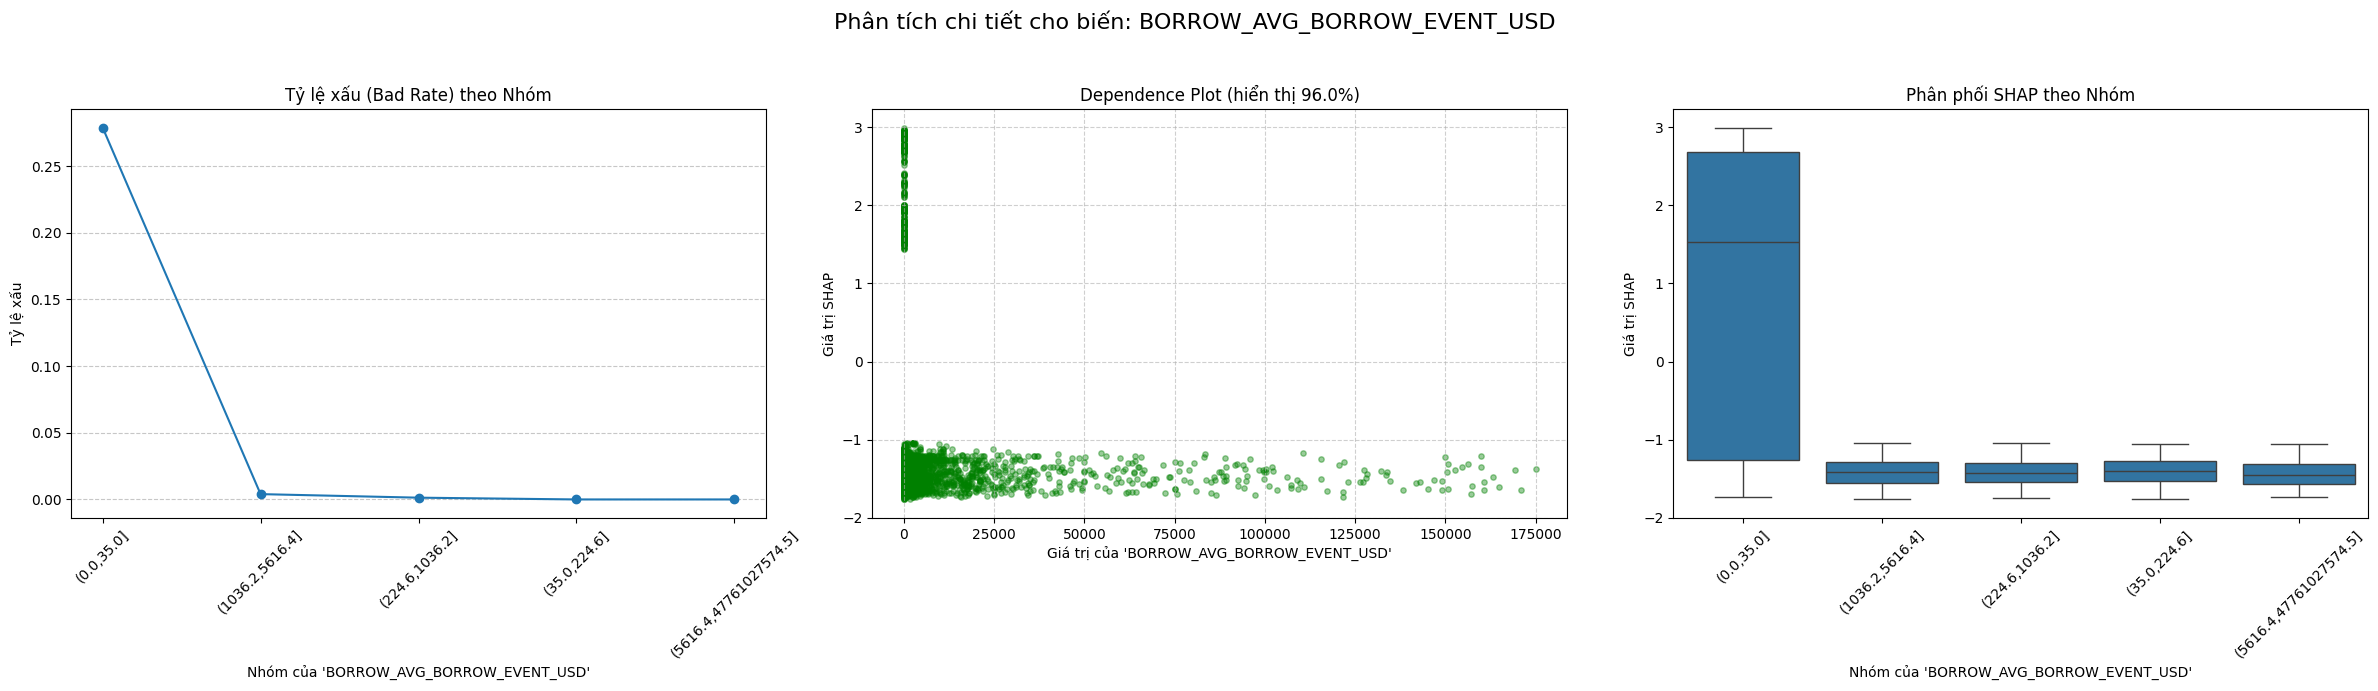


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_MAX_BORROW_EVENT_USD' <<<<<<


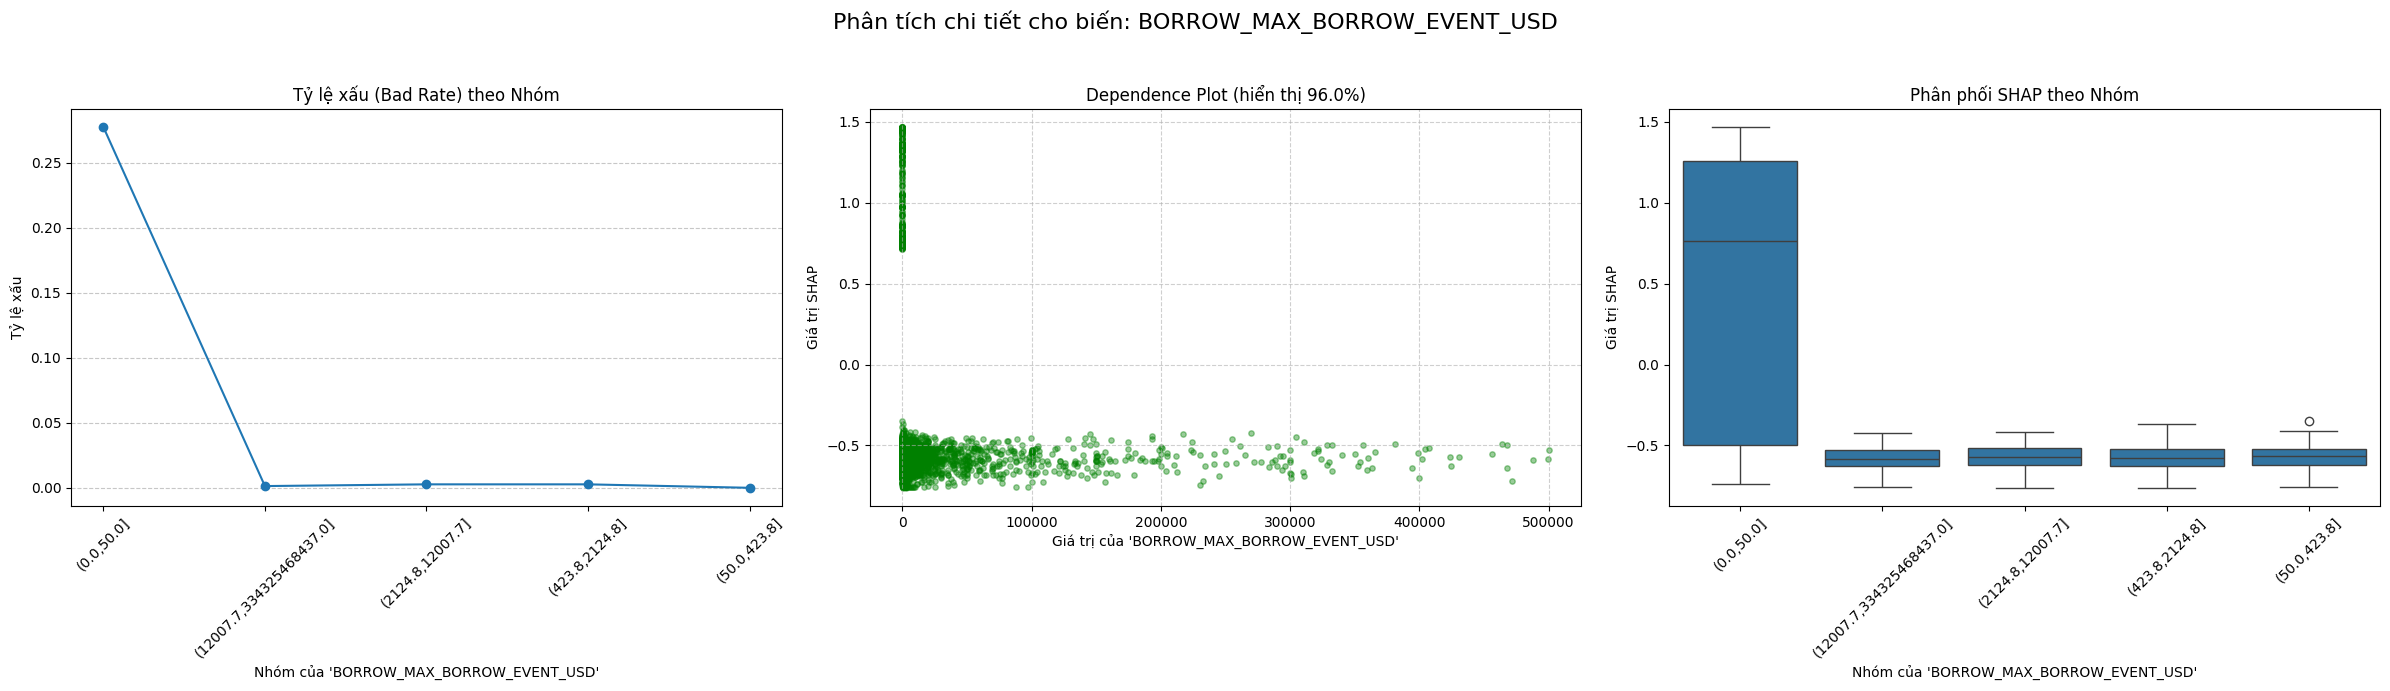


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_BORROW_EVENT_COUNT' <<<<<<


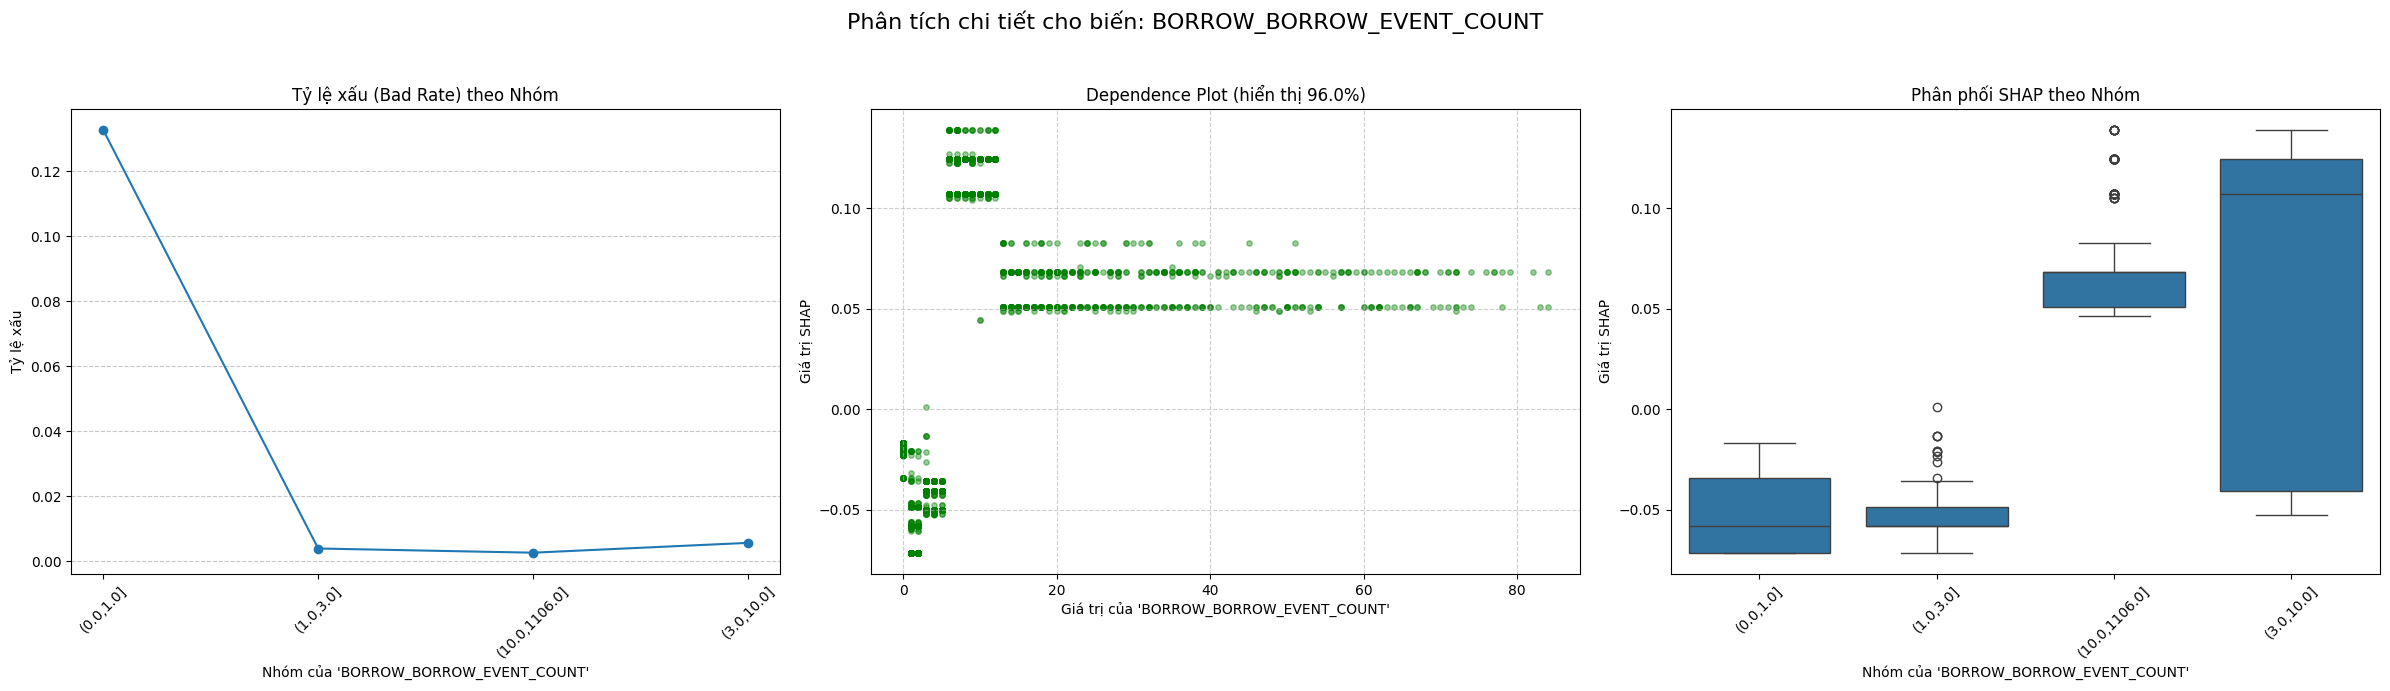


>>>>>> Đang tạo biểu đồ cho biến: 'depositInUSD' <<<<<<


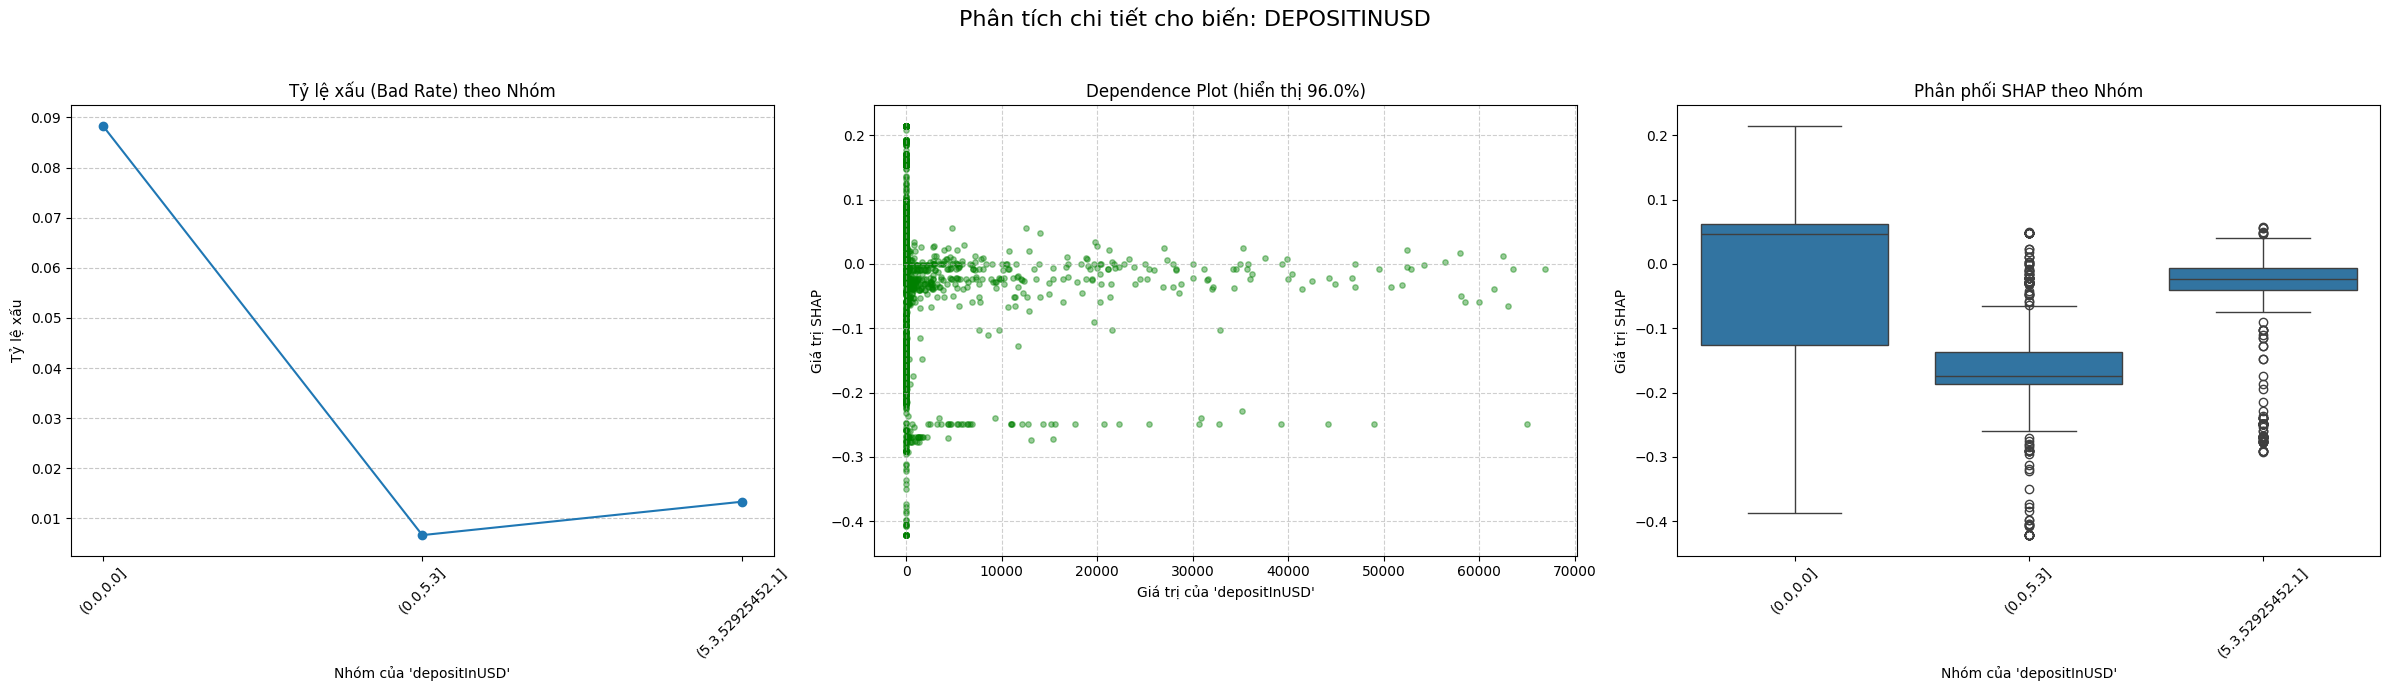


>>>>>> Đang tạo biểu đồ cho biến: 'HOLDING_AVG_TRANSACTION_VALUE_USD' <<<<<<


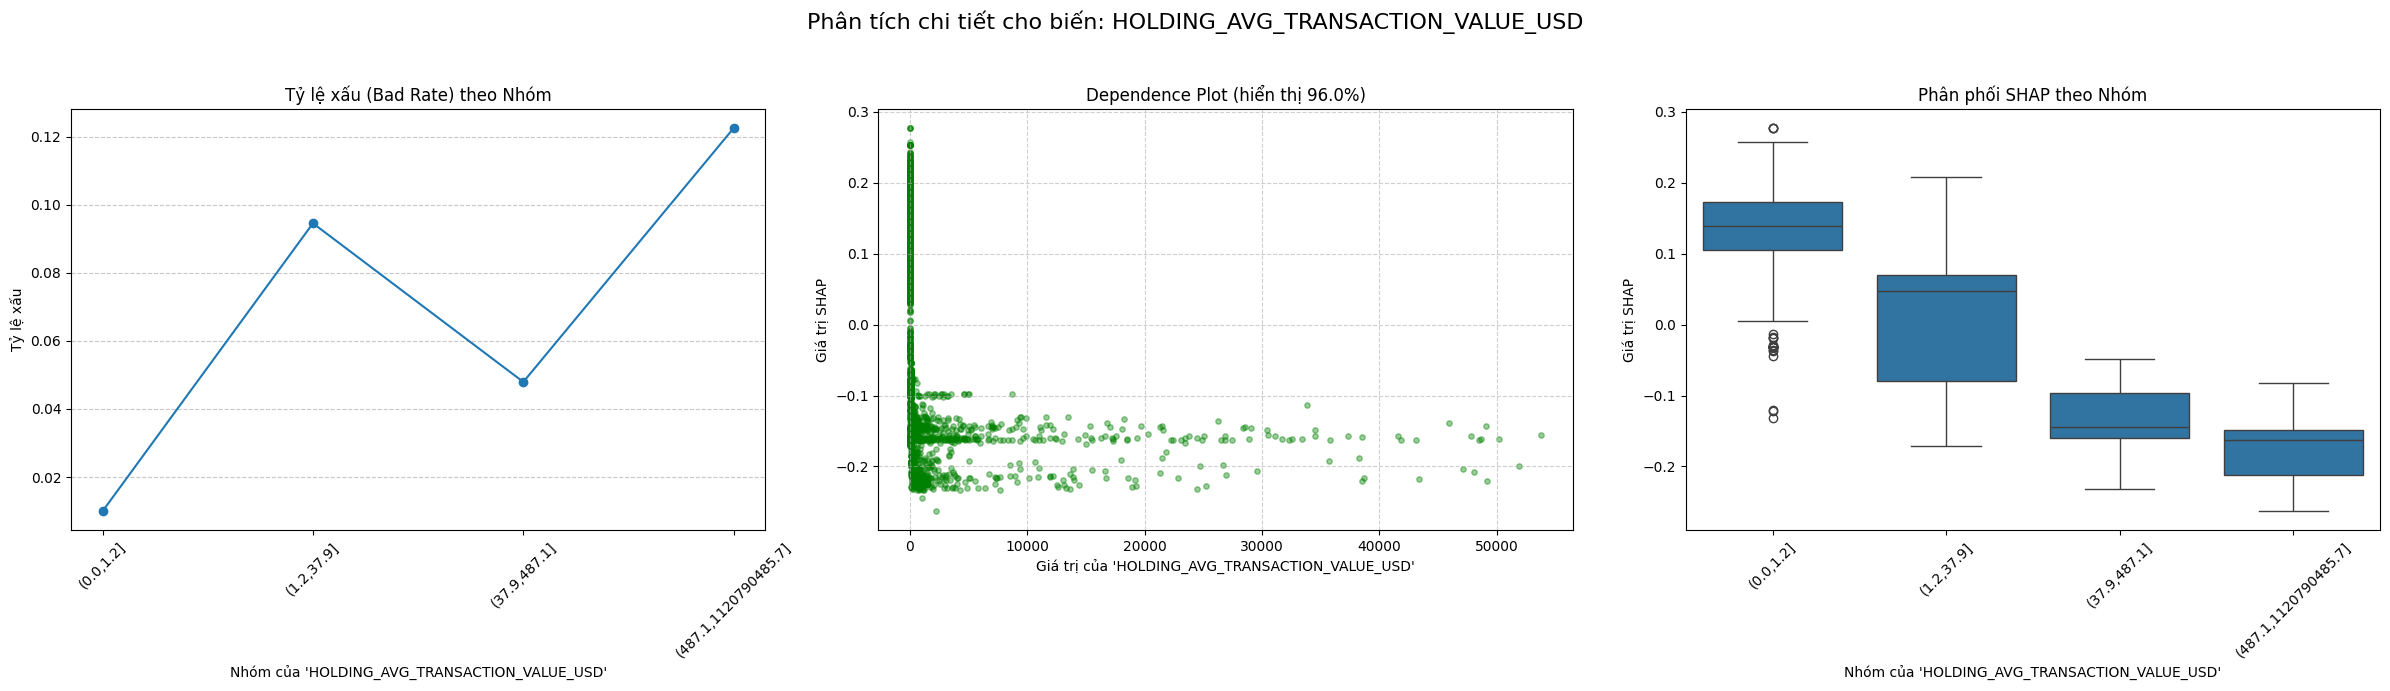


>>>>>> Đang tạo biểu đồ cho biến: 'balanceInUSD' <<<<<<


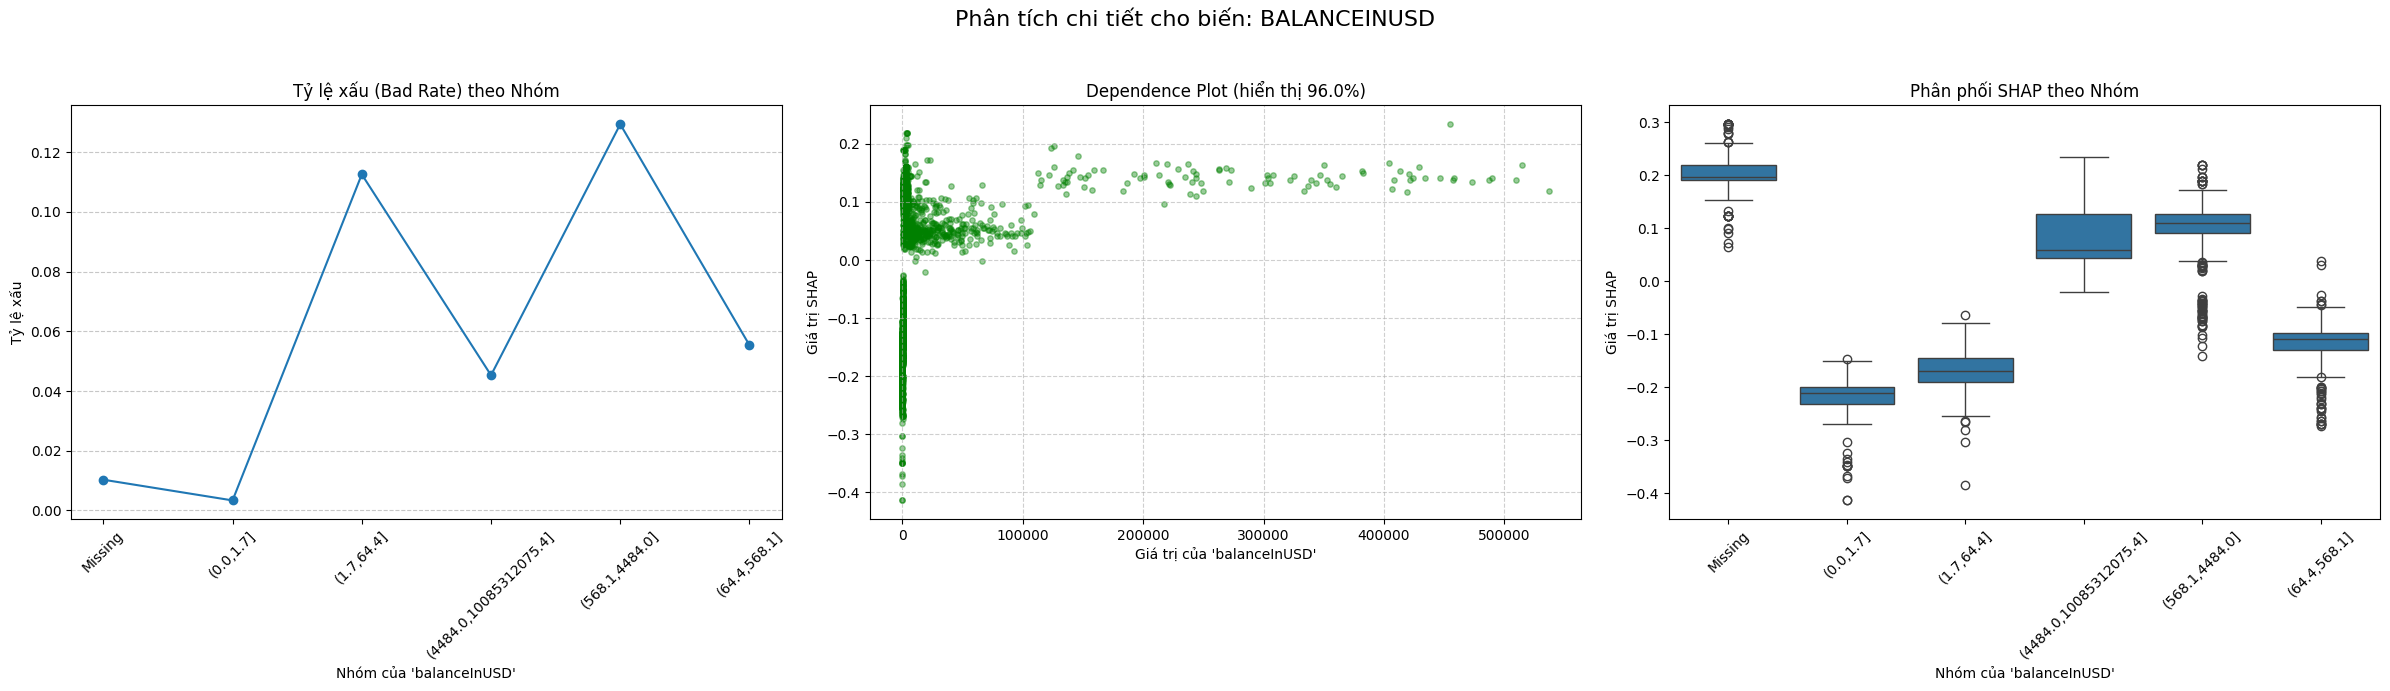


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_TO_DEPOSIT_AND_BALANCE' <<<<<<


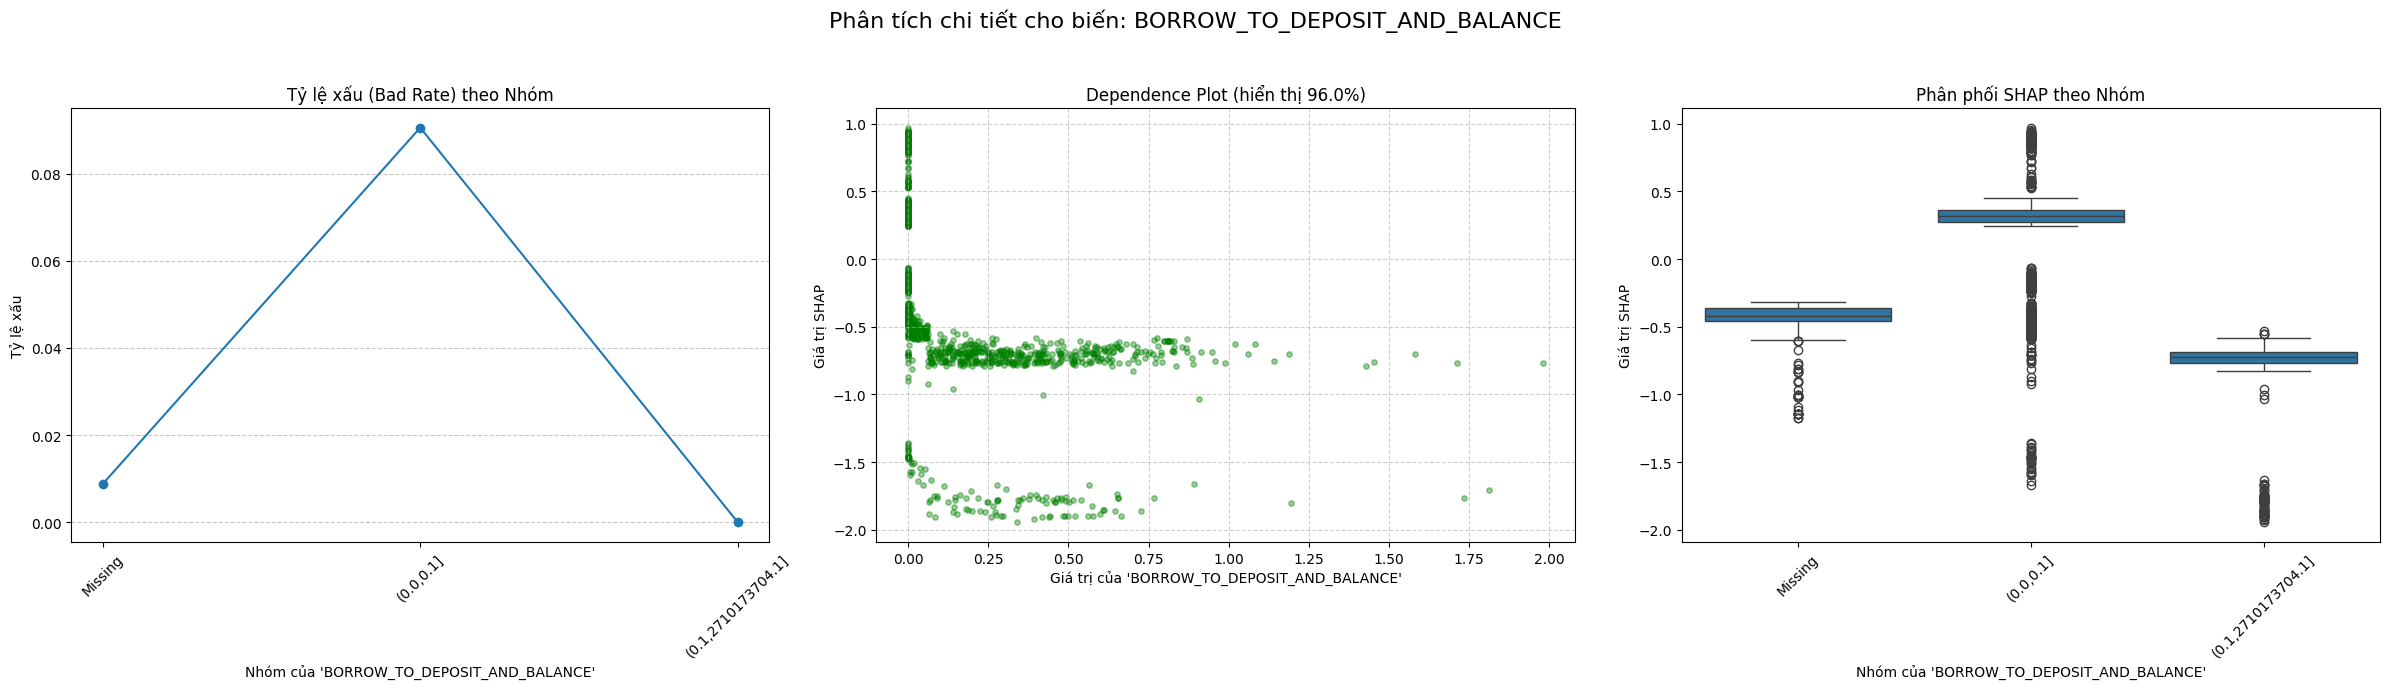


>>>>>> Đang tạo biểu đồ cho biến: 'TOTAL_PORTFOLIO_USD' <<<<<<


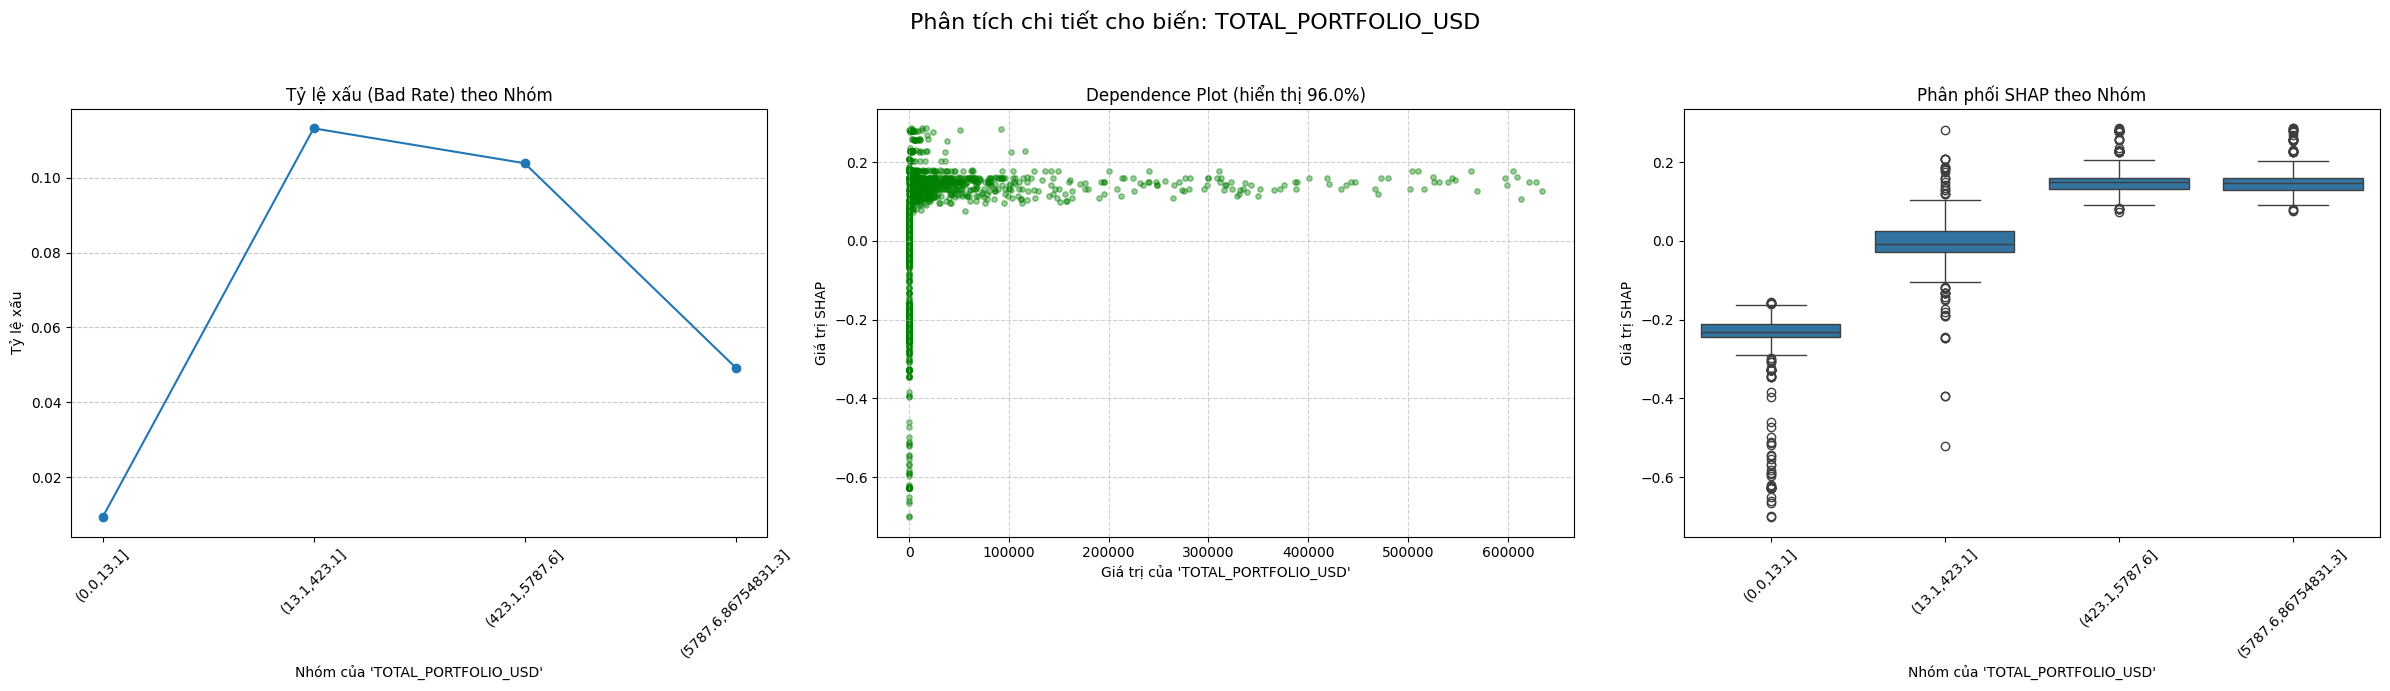


>>>>>> Đang tạo biểu đồ cho biến: 'MAX_INCREASE_PERCENT' <<<<<<


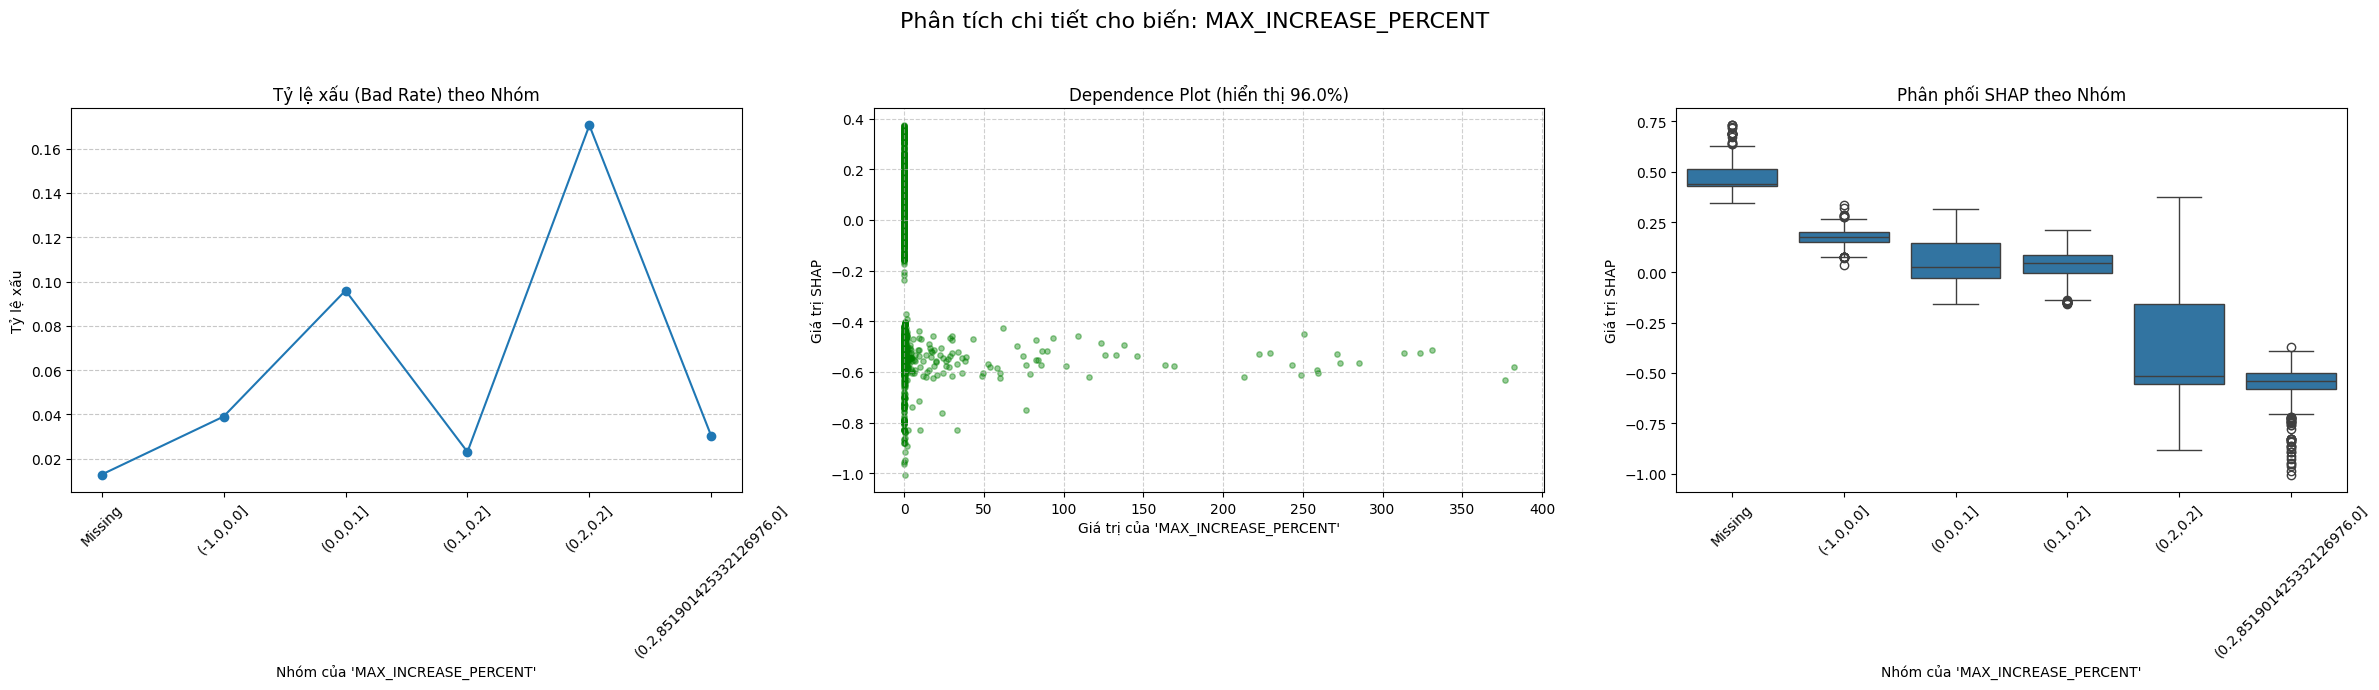


>>>>>> Đang tạo biểu đồ cho biến: 'DEPOSIT_TOTAL_CHANGE_COUNT' <<<<<<


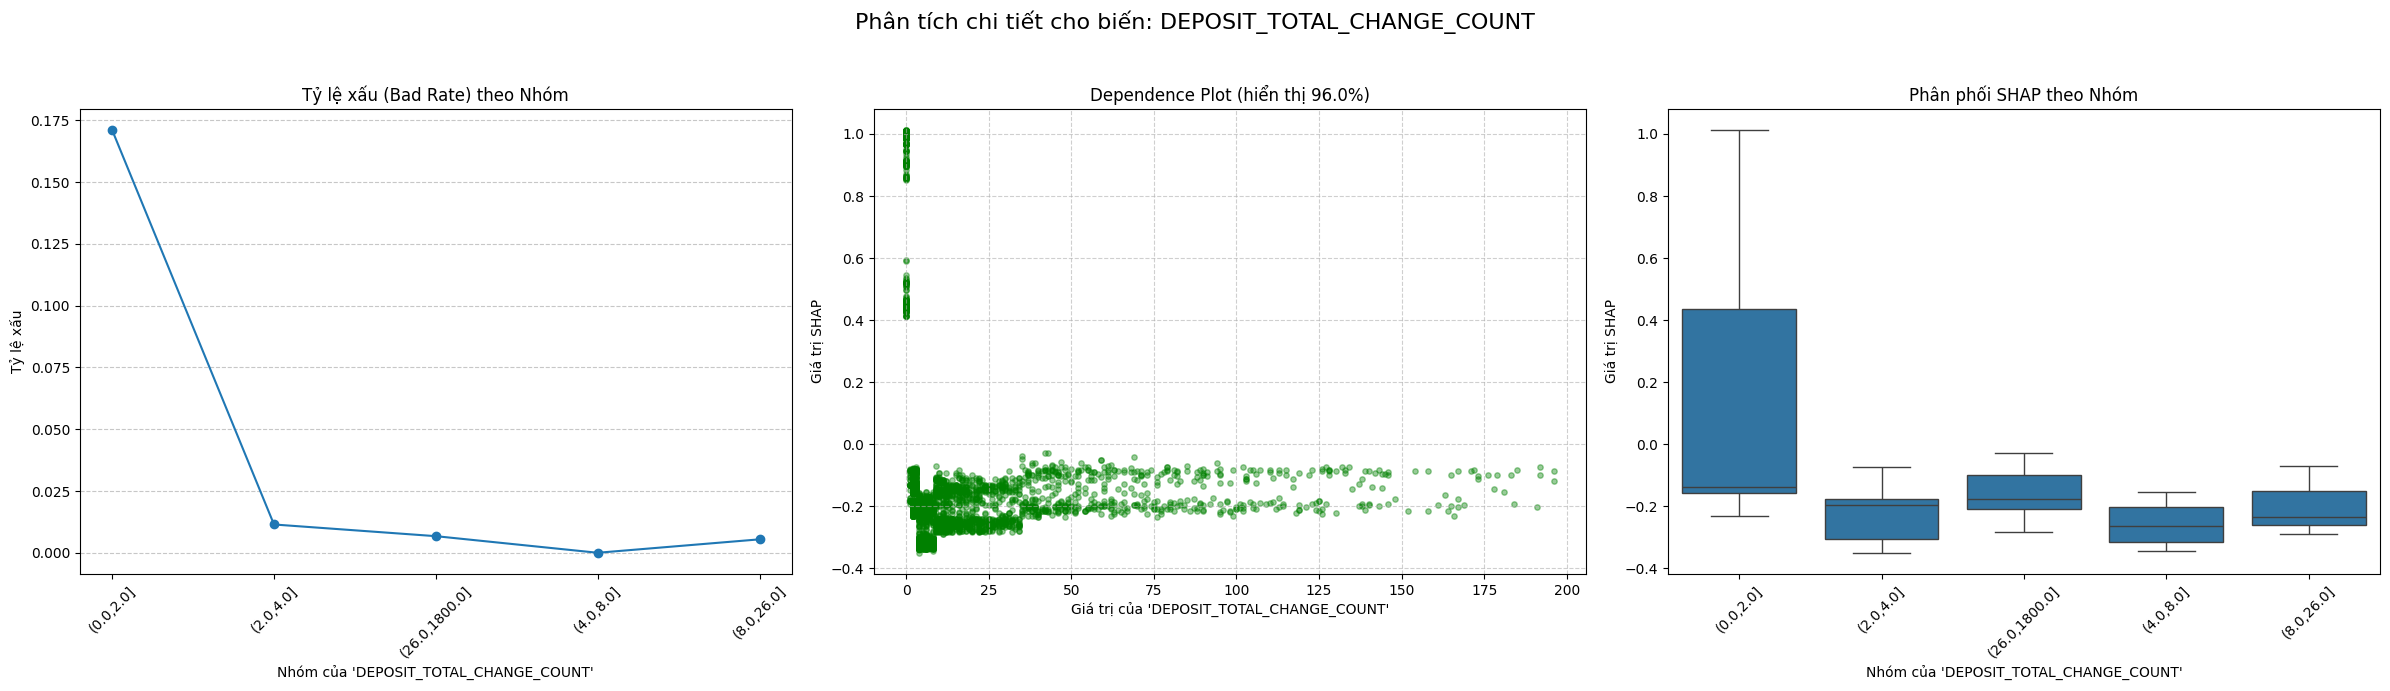


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_TO_DEPOSIT' <<<<<<


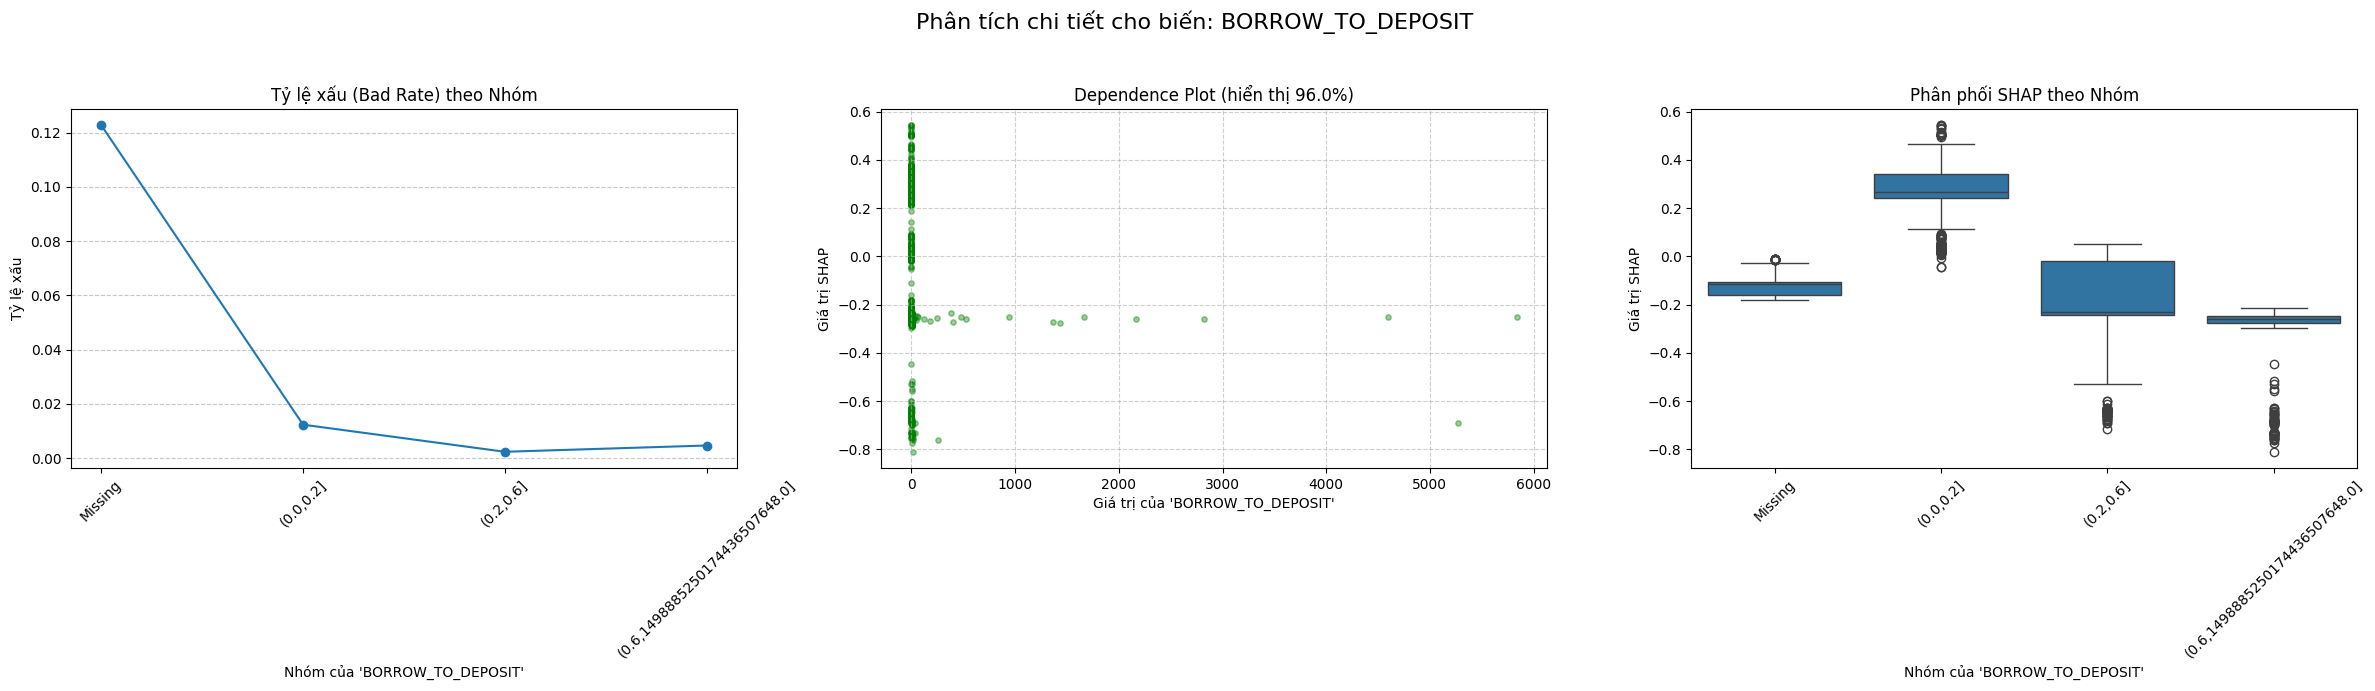


>>>>>> Đang tạo biểu đồ cho biến: 'DEPOSIT_TOTAL_INFLOW_USD_30D' <<<<<<


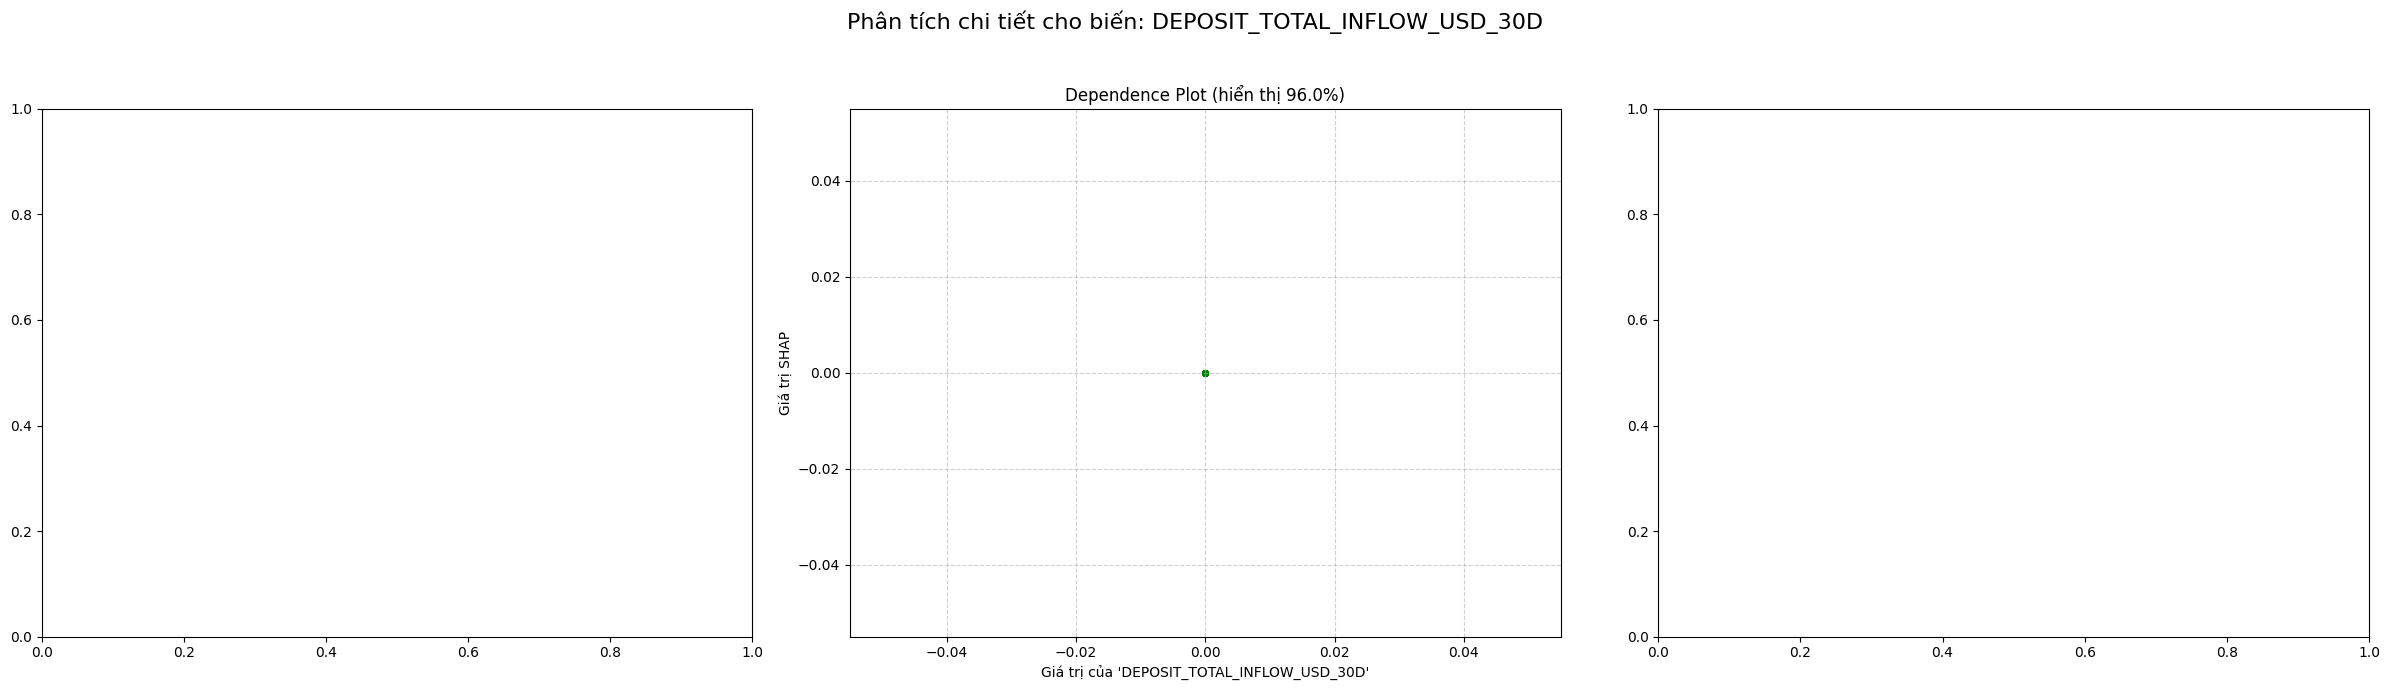


>>>>>> Đang tạo biểu đồ cho biến: 'DEPOSIT_WALLET_AGE_DAYS' <<<<<<


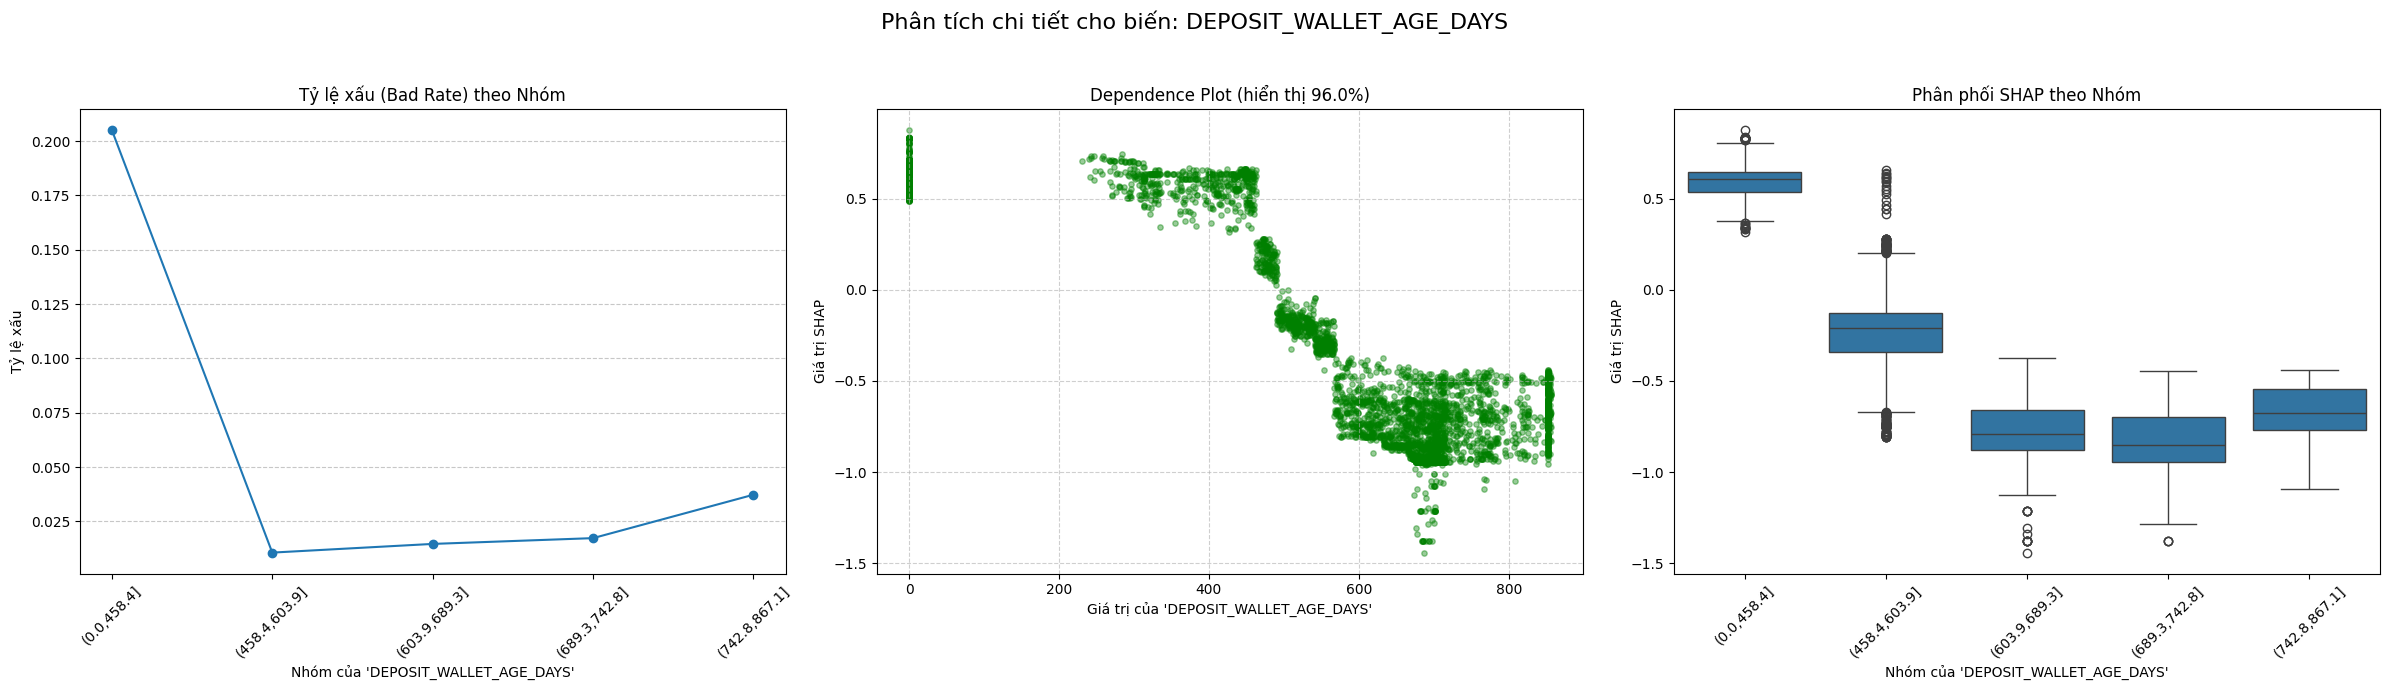


>>>>>> Đang tạo biểu đồ cho biến: 'DEPOSIT_INFLOW_OUTFLOW_RATIO' <<<<<<


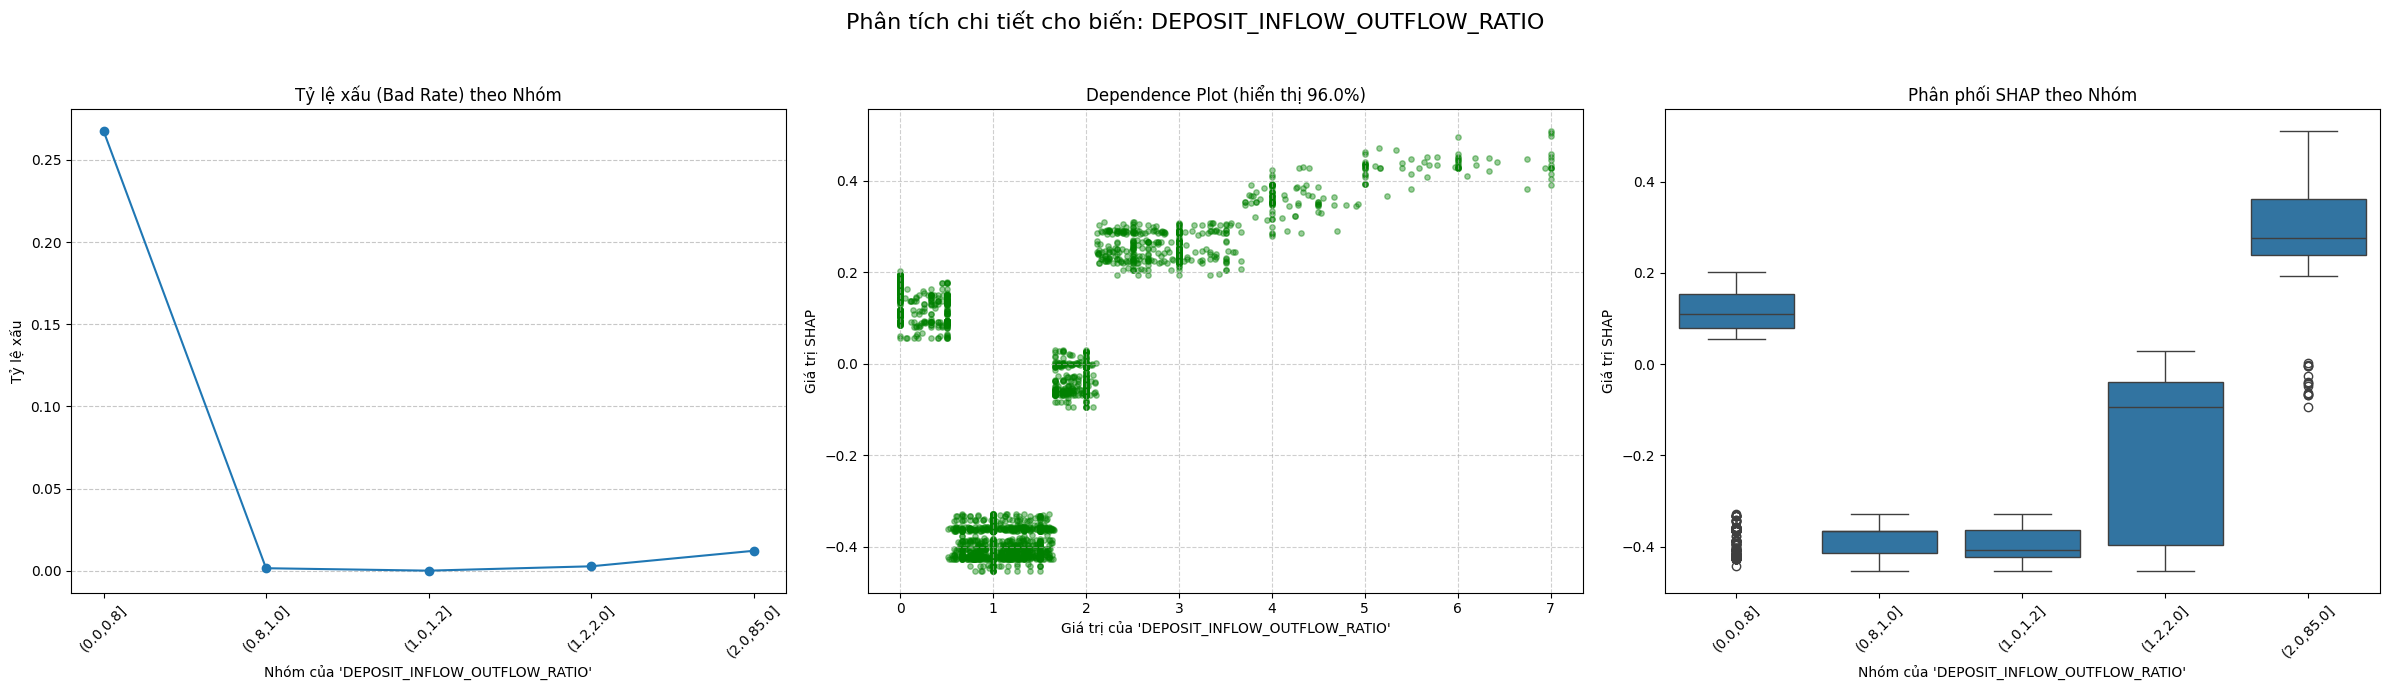


>>>>>> Đang tạo biểu đồ cho biến: 'DEPOSIT_TOTAL_OUTFLOW_USD_30D' <<<<<<


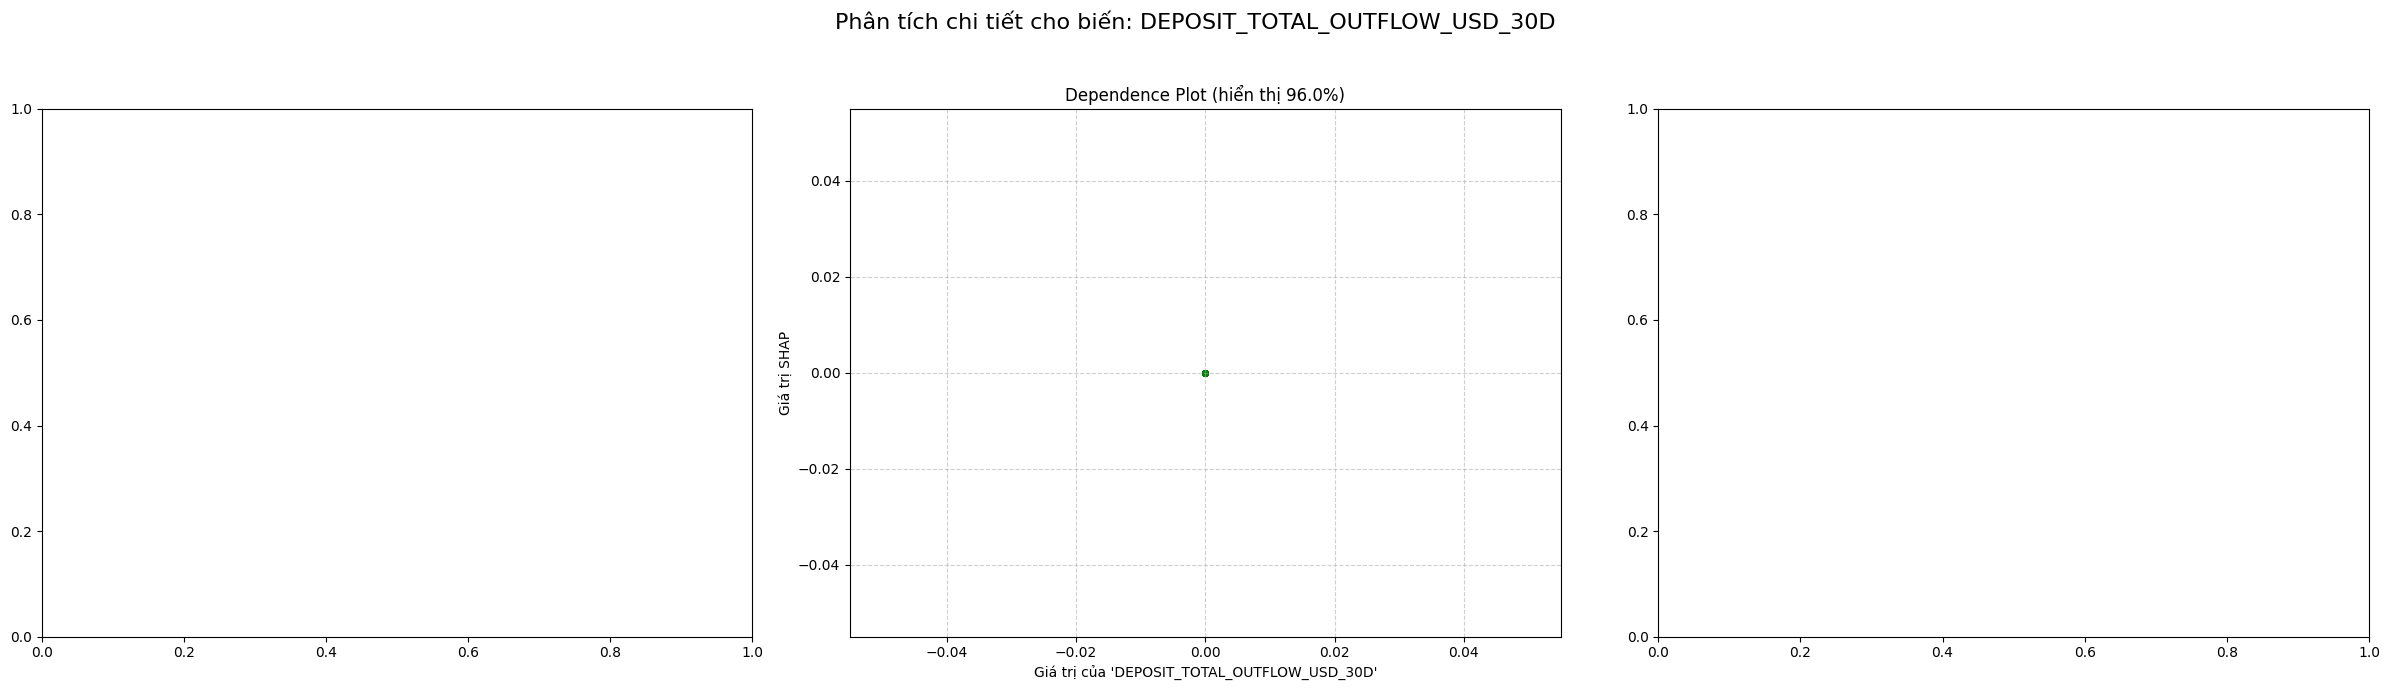


>>>>>> Đang tạo biểu đồ cho biến: 'TOTAL_BORROW_TO_DEPOSIT' <<<<<<


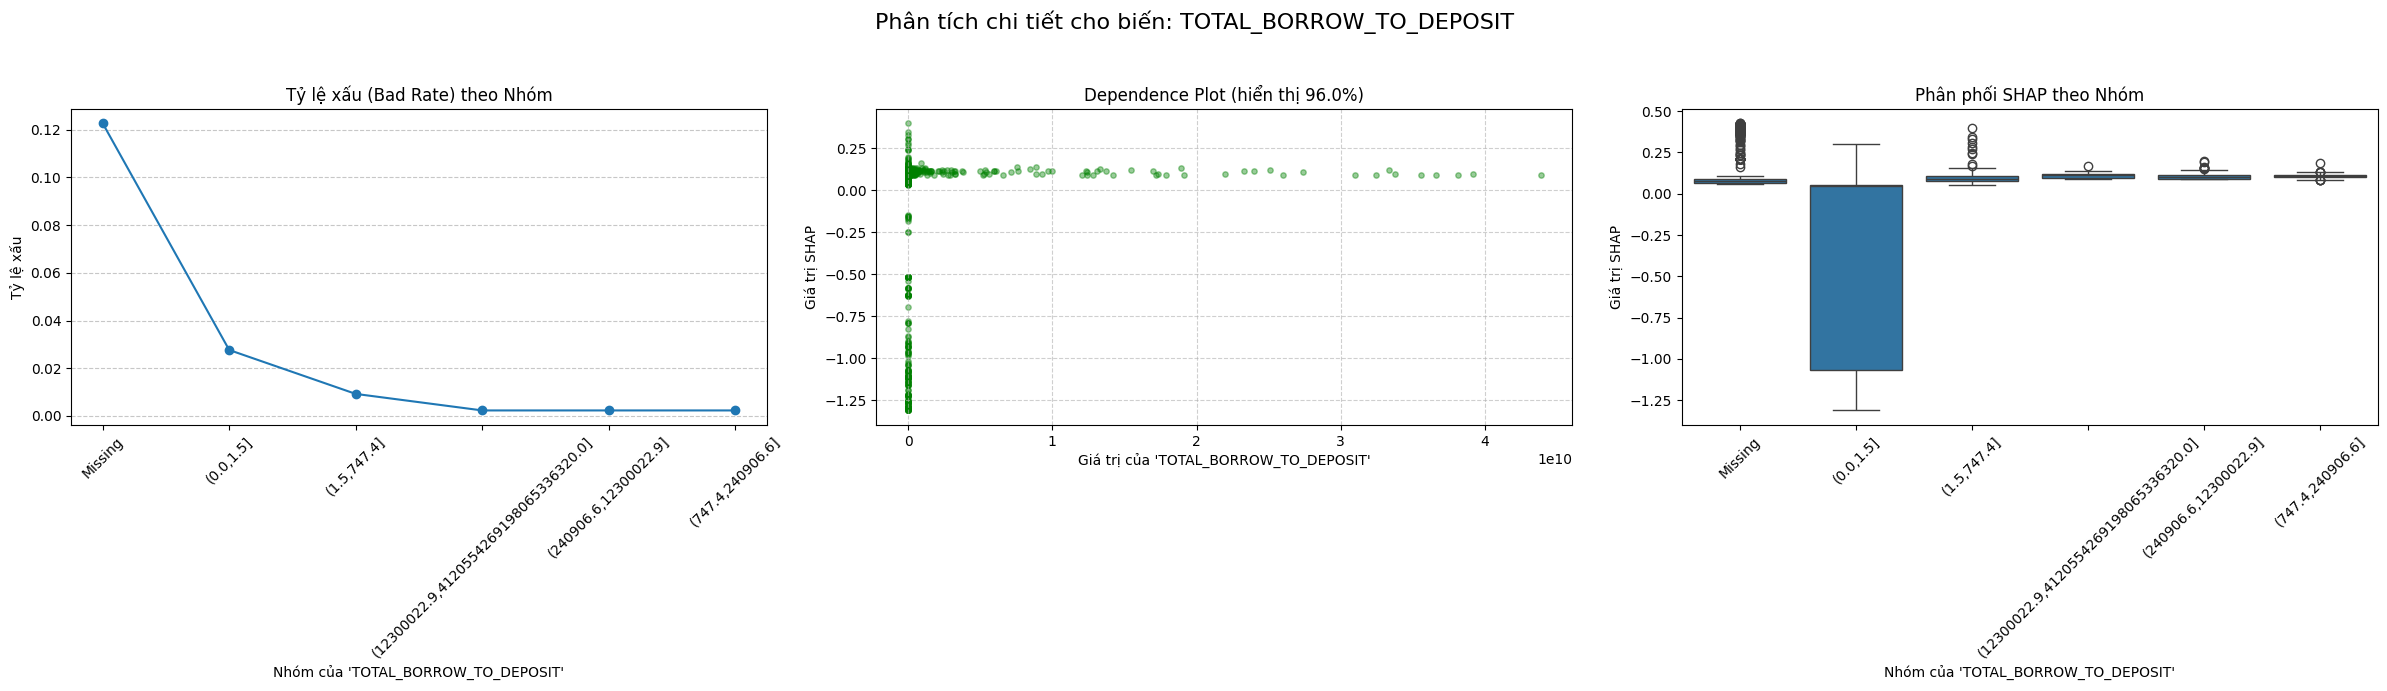


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_DAYS_SINCE_LAST_BORROW' <<<<<<


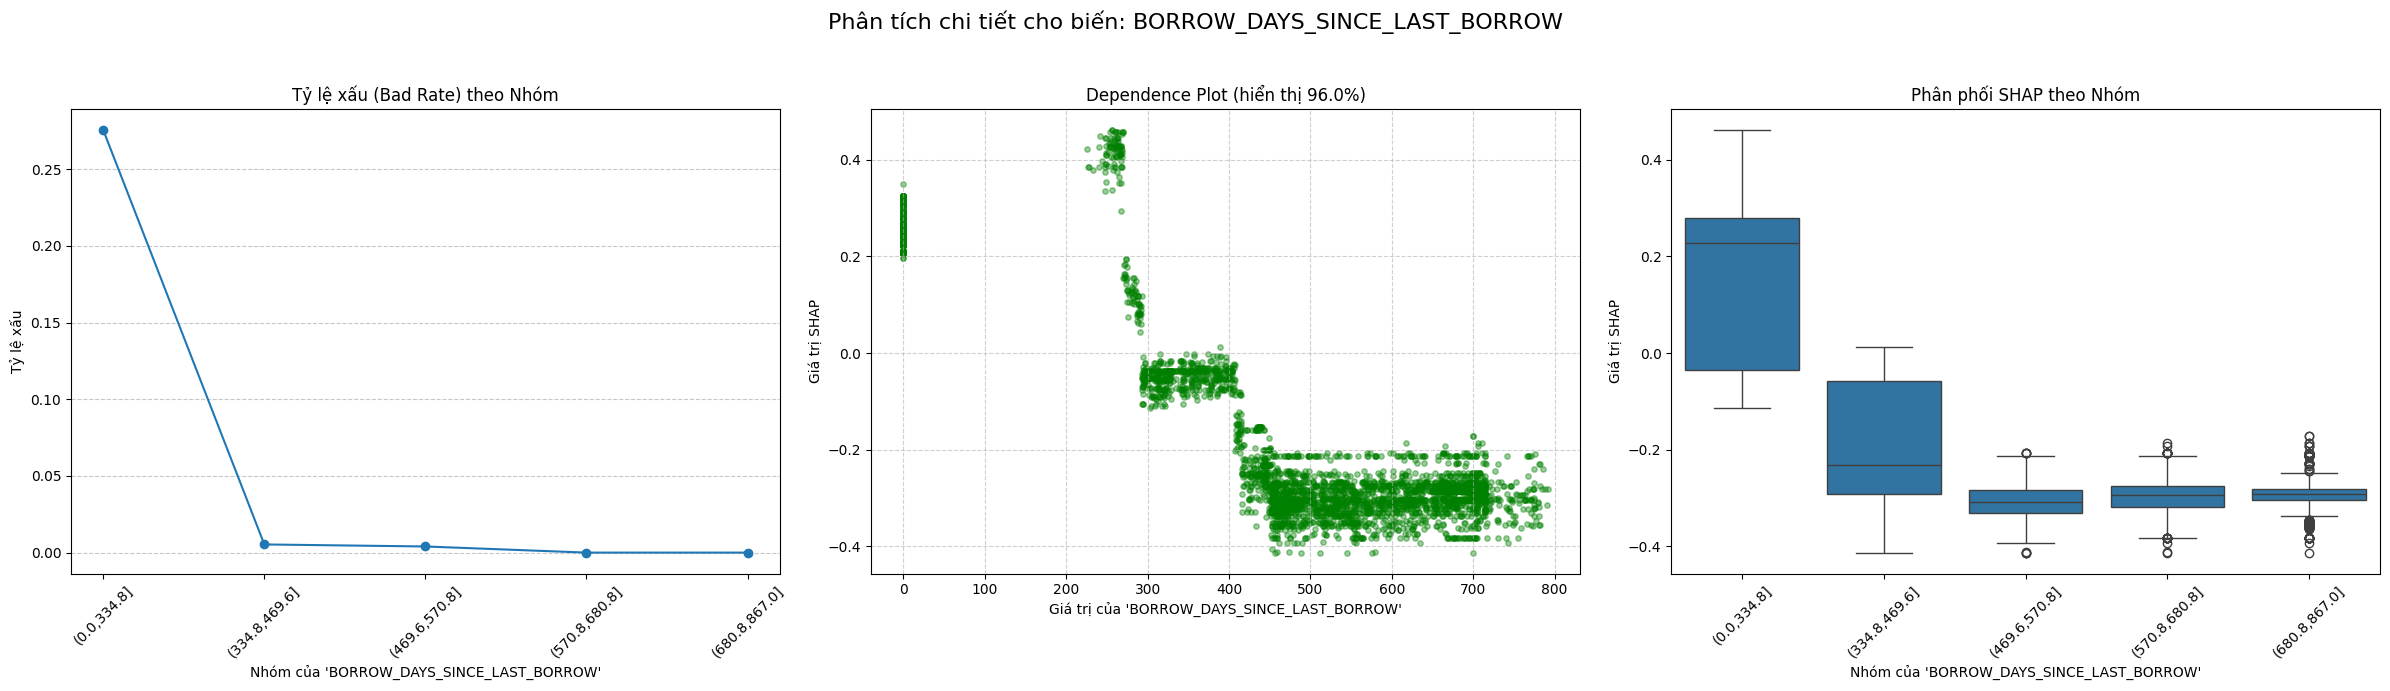


>>>>>> Đang tạo biểu đồ cho biến: 'BORROW_DUST_LOAN_COUNT' <<<<<<


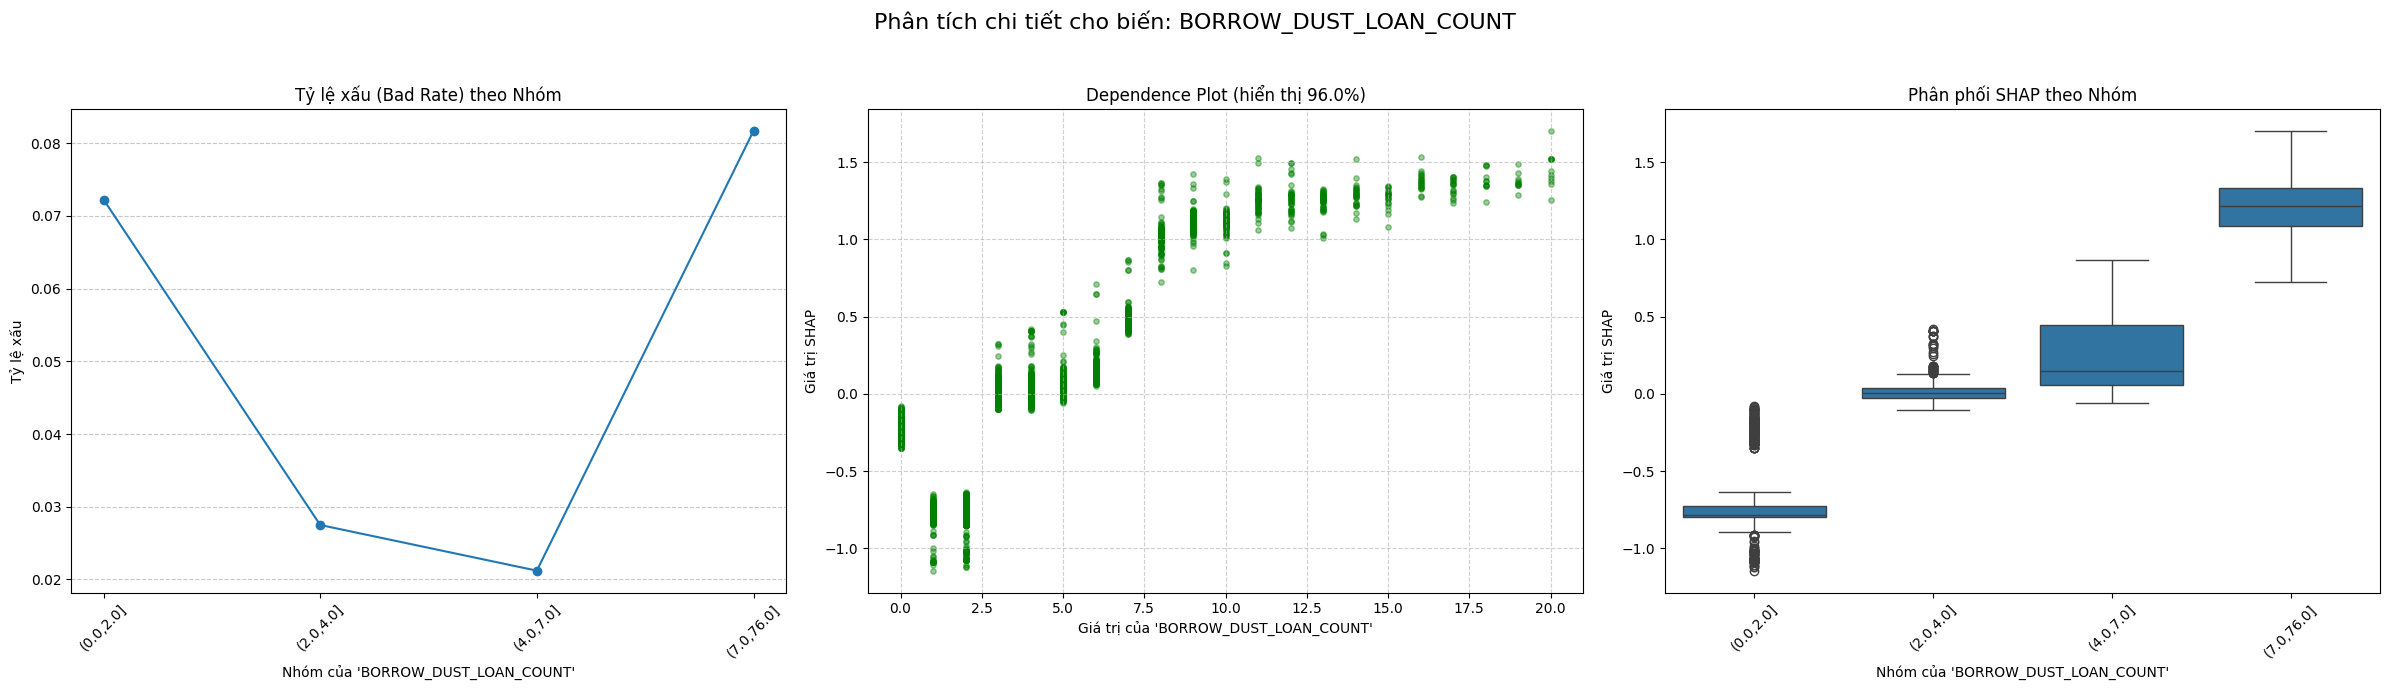

In [50]:
# Tính toán SHAP values
explainer = shap.TreeExplainer(model)
shap_values_output = explainer(X_train)
# -----------------------------------------------------------------


def plot_final_analysis(X, y, shap_values, feat, bins=5, lower_percentile=2, upper_percentile=98, positive_class_index=1):
    """
    Vẽ 3 biểu đồ phân tích chi tiết cho một feature, tích hợp logic lọc quantile đáng tin cậy.
    """
    # --- 1. Chuẩn bị DataFrame cơ sở ---
    feat_idx = X.columns.get_loc(feat)

    # Xử lý SHAP values để lấy đúng lớp "dương" (lớp 1)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_vals_feat = shap_values[positive_class_index][:, feat_idx]
    elif hasattr(shap_values, 'values') and shap_values.values.ndim == 3:
        shap_vals_feat = shap_values.values[:, feat_idx, positive_class_index]
    else:
        shap_vals_feat = shap_values[:, feat_idx]

    df_base = pd.DataFrame({
        'feature': pd.to_numeric(X[feat], errors='coerce'),
        'shap': shap_vals_feat,
        'y': y
    }).reset_index(drop=True)

    # --- 2. Chuẩn bị dữ liệu cho Biểu đồ 1 & 3 (Bad Rate & Box Plot) ---
    df_grouped = df_base.copy()
    non_null_mask = df_grouped['feature'].notnull()
    df_grouped['group'] = np.nan

    if non_null_mask.sum() > 0:
        try:
            df_grouped.loc[non_null_mask, 'group'] = pd.qcut(df_grouped.loc[non_null_mask, 'feature'], q=bins, duplicates='drop', labels=False)
            _, bin_edges = pd.qcut(df_grouped.loc[non_null_mask, 'feature'], q=bins, duplicates='drop', retbins=True)
            bin_labels = [f'({bin_edges[i]:.1f},{bin_edges[i+1]:.1f}]' for i in range(len(bin_edges)-1)]
            map_dict = dict(enumerate(bin_labels))
            df_grouped['group'] = df_grouped['group'].map(map_dict)
        except (ValueError, IndexError):
            df_grouped.loc[non_null_mask, 'group'] = pd.cut(df_grouped.loc[non_null_mask, 'feature'], bins=bins, duplicates='drop', labels=False)
            bin_labels = [f'Bin {i}' for i in range(int(df_grouped['group'].nunique(dropna=True)))]
            map_dict = dict(enumerate(bin_labels))
            df_grouped['group'] = df_grouped['group'].map(map_dict)

    if (~non_null_mask).any():
        df_grouped.loc[~non_null_mask, 'group'] = "Missing"

    all_groups = df_grouped['group'].dropna().unique().tolist()
    numeric_groups = sorted([g for g in all_groups if g != "Missing"])
    plot_order = (["Missing"] if "Missing" in all_groups else []) + numeric_groups
    df_grouped['group'] = pd.Categorical(df_grouped['group'], categories=plot_order, ordered=True)

    # --- 3. Bắt đầu vẽ ---
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(f"Phân tích chi tiết cho biến: {feat.upper()}", fontsize=16)

    # --- Biểu đồ 1: Bad Rate Plot ---
    if not df_grouped['group'].isnull().all():
        bad_rate_data = df_grouped.groupby('group', observed=True)['y'].mean()
        axs[0].plot(bad_rate_data.index.astype(str), bad_rate_data.values, marker='o', linestyle='-')
        axs[0].set_title("Tỷ lệ xấu (Bad Rate) theo Nhóm")
        axs[0].set_ylabel("Tỷ lệ xấu")
        axs[0].set_xlabel(f"Nhóm của '{feat}'")
        # ĐÃ SỬA LỖI: Xóa ha='right'
        axs[0].tick_params(axis='x', rotation=45)
        axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    # --- Biểu đồ 2: Dependence Plot ---
    df_for_plot2 = df_base.dropna(subset=['feature'])

    if not df_for_plot2.empty:
        lower_bound = np.nanpercentile(df_for_plot2['feature'], lower_percentile)
        upper_bound = np.nanpercentile(df_for_plot2['feature'], upper_percentile)

        mask = (df_for_plot2['feature'] >= lower_bound) & (df_for_plot2['feature'] <= upper_bound)

        if mask.sum() >= 10:
            df_for_plot2 = df_for_plot2[mask]

    axs[1].scatter(df_for_plot2['feature'], df_for_plot2['shap'], alpha=0.4, color='green', s=15)
    axs[1].set_title(f"Dependence Plot (hiển thị {upper_percentile - lower_percentile:.1f}%)")
    axs[1].set_xlabel(f"Giá trị của '{feat}'")
    axs[1].set_ylabel("Giá trị SHAP")
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # --- Biểu đồ 3: Box Plot ---
    if not df_grouped['group'].isnull().all():
        sns.boxplot(x='group', y='shap', data=df_grouped, ax=axs[2], order=plot_order)
        axs[2].set_title("Phân phối SHAP theo Nhóm")
        axs[2].set_xlabel(f"Nhóm của '{feat}'")
        axs[2].set_ylabel("Giá trị SHAP")
        # ĐÃ SỬA LỖI: Xóa ha='right'
        axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Cách sử dụng ---
for feature_name in X_train.columns:
    print(f"\n>>>>>> Đang tạo biểu đồ cho biến: '{feature_name}' <<<<<<")
    plot_final_analysis(
        X=X_train,
        y=y_train,
        shap_values=shap_values_output.values if hasattr(shap_values_output, 'values') else shap_values_output,
        feat=feature_name
    )

core function for API service

In [ ]:
features = ["BORROW_AVG_BORROW_EVENT_USD", "BORROW_MAX_BORROW_EVENT_USD", "BORROW_BORROW_EVENT_COUNT", "depositInUSD", "HOLDING_AVG_TRANSACTION_VALUE_USD", "balanceInUSD", "BORROW_TO_DEPOSIT_AND_BALANCE", "TOTAL_PORTFOLIO_USD", "MAX_INCREASE_PERCENT", "DEPOSIT_TOTAL_CHANGE_COUNT", "BORROW_TO_DEPOSIT", "DEPOSIT_TOTAL_INFLOW_USD_30D", "DEPOSIT_WALLET_AGE_DAYS", "DEPOSIT_INFLOW_OUTFLOW_RATIO", "DEPOSIT_TOTAL_OUTFLOW_USD_30D", "TOTAL_BORROW_TO_DEPOSIT", "BORROW_DAYS_SINCE_LAST_BORROW", "BORROW_DUST_LOAN_COUNT"]
model_path = "/content/drive/MyDrive/tcb hack/credit_score_model.pkl"
feature_store_path = "/content/drive/MyDrive/tcb hack/final_feature_store.parquet.gzip"
holding_log_path = "/content/drive/MyDrive/tcb hack/holding_token_symbol.parquet.gzip"

df = pd.read_parquet(feature_store_path)
holding_log = pd.read_parquet(holding_log_path)
df = pd.merge(df, holding_log, on='_id', how='left')

In [ ]:
merged_df = holding_log

In [ ]:
tokens_normalized = pd.json_normalize(merged_df['TOKENS_AS_SYMBOLS'])

# Bước 2: Kết hợp lại với cột _id và các cột dữ liệu khác từ DataFrame gốc
df_with_token_cols = pd.concat([merged_df.drop('TOKENS_AS_SYMBOLS', axis=1), tokens_normalized], axis=1)

# Bước 3: Dùng `melt` để chuyển từ định dạng "rộng" sang định dạng "dài"
# 'id_vars' là các cột bạn muốn giữ nguyên
# 'var_name' là tên cột mới cho các tên token (ETH, USDC, BNB)
# 'value_name' là tên cột mới cho các giá trị số lượng


In [ ]:
long_format_df = pd.melt(
    df_with_token_cols,
    id_vars='_id',
    var_name='symbol',
    value_name='amount_usd'
)

# Bước 4 (Tùy chọn): Loại bỏ các hàng không có giá trị (NaN)
long_format_df.dropna(subset=['amount_usd'], inplace=True)
long_format_df.sort_values('_id', inplace=True)

In [ ]:
long_format_df.reset_index(drop=True, inplace=True)

In [ ]:
long_format_df.to_parquet("/content/drive/MyDrive/tcb hack/holding_token_symbol.parquet.gzip", compression="gzip")

In [ ]:
def credit_score_lambda_function(address):
  features = ["BORROW_AVG_BORROW_EVENT_USD", "BORROW_MAX_BORROW_EVENT_USD", "BORROW_BORROW_EVENT_COUNT", "depositInUSD", "HOLDING_AVG_TRANSACTION_VALUE_USD", "balanceInUSD", "BORROW_TO_DEPOSIT_AND_BALANCE", "TOTAL_PORTFOLIO_USD", "MAX_INCREASE_PERCENT", "DEPOSIT_TOTAL_CHANGE_COUNT", "BORROW_TO_DEPOSIT", "DEPOSIT_TOTAL_INFLOW_USD_30D", "DEPOSIT_WALLET_AGE_DAYS", "DEPOSIT_INFLOW_OUTFLOW_RATIO", "DEPOSIT_TOTAL_OUTFLOW_USD_30D", "TOTAL_BORROW_TO_DEPOSIT", "BORROW_DAYS_SINCE_LAST_BORROW", "BORROW_DUST_LOAN_COUNT"]
  model_path = "/content/drive/MyDrive/tcb hack/credit_score_model.pkl"
  feature_store_path = "/content/drive/MyDrive/tcb hack/final_feature_store.parquet.gzip"
  holding_log_path = "/content/drive/MyDrive/tcb hack/holding_token_symbol.parquet.gzip"

  df = pd.read_parquet(feature_store_path)
  if address not in df['_id'].values:
    return "Địa chỉ ví không tồn tại trong CSDL, vui lòng nhập địa chỉ ví khác."

  holding_log = pd.read_parquet(holding_log_path)
  address_holding_df = holding_log[holding_log['_id']==address]
  return address_holding_df
  model_input = df[df["_id"]==address]
  ################################
  holdings = model_input["TOKENS_AS_SYMBOLS"].values[0] # df chứa thông tin token ví đang nắm giữ (symbo)
#####################################
  model_input = model_input[features]

  with open(model_path, 'rb') as f:
    model = pickle.load(f)
  prediction = model.predict_proba(model_input)[:, 1]
  address_credit_score = prediction[0]
  address_credit_score = int((1-address_credit_score)*100)
  if address_credit_score <20:
    score_type = "E Tier"
  elif address_credit_score <40:
    score_type = "D Tier"
  elif address_credit_score <60:
    score_type = "C Tier"
  elif address_credit_score <80:
    score_type = "B Tier"
  else:
    score_type = "A Tier"

#########################################################################################
####################################################

  output = {"address": address,
            "credit_score": address_credit_score,
            "score_type": score_type}

  return output
